# 动量因子

我们的基本动量因子库如下:

In [1]:
# coding=utf-8
import time
import sys
import os
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")

from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdate
from tqdm import tqdm_notebook

pd.set_option("max_rows", None, "max_colwidth", 1000)
FactorInfo = pd.read_csv(".\\csv\\动量因子.csv", header=0, index_col=0, encoding="utf-8")
display(FactorInfo)

,因子描述,排序方向,数据类型
因子名称,,,
RTN_1D,复权收盘价 / 复权收盘价_1天前 - 1,升序,double
RTN_5D,复权收盘价 / 复权收盘价_5天前 - 1,升序,double
RTN_20D,复权收盘价 / 复权收盘价_20天前 - 1,升序,double
RTN_60D,复权收盘价 / 复权收盘价_60天前 - 1,升序,double
RTN_120D,复权收盘价 / 复权收盘价_120天前 - 1,升序,double
RTN_180D,复权收盘价 / 复权收盘价_180天前 - 1,升序,double
RTN_240D,复权收盘价 / 复权收盘价_240天前 - 1,升序,double
RTN_720D,复权收盘价 / 复权收盘价_720天前 - 1,升序,double
RTN_1200D,复权收盘价 / 复权收盘价_1200天前 - 1,升序,double


说明：
* 后缀 nD: 表示使用过去多长的时间窗口(以日为单位)数据来计算因子值，比如 1D 表示一个交易日

下面对动量类因子进行 IC 和分位数组合测试其选股能力:

==========历史回测==========
1. 初始化耗时 : 0.03
2. 循环计算

100%|████████████████████████████████████████| 132/132 [13:53<00:00,  6.31s/it]


耗时 : 844.23
3. 结果生成耗时 : 15.62
总耗时 : 859.89


,平均值,标准差,最小值,最大值,IC_IR,t统计量,平均股票数,IC×Sqrt(N),有效期数
BS_Amount,-2.91%,8.53%,-24.02%,19.71%,-0.3416,-3.33,1663.99,-1.19,95
BS_Volume,-1.31%,9.85%,-26.59%,32.78%,-0.1332,-1.30,1664.01,-0.54,95
CL,6.72%,13.68%,-44.00%,42.96%,0.4911,5.62,2251.00,3.19,131
MaxReturn_20D,6.64%,12.44%,-42.71%,40.85%,0.5336,6.11,2242.53,3.14,131
MomentumChg_5D,3.08%,12.41%,-33.75%,52.39%,0.2479,2.84,2249.66,1.46,131
PriceTrend_240D,2.92%,14.53%,-40.92%,42.78%,0.2012,2.30,2108.58,1.34,131
Price_52WHigh,-2.65%,12.43%,-29.96%,22.20%,-0.2132,-2.44,1867.11,-1.15,131
RTN_1200D,6.91%,15.18%,-39.07%,54.81%,0.4553,5.21,1472.64,2.65,131
RTN_120D,5.82%,15.04%,-27.40%,48.93%,0.3873,4.43,1949.21,2.57,131
RTN_180D,4.98%,15.25%,-39.48%,44.58%,0.3266,3.74,1888.59,2.16,131

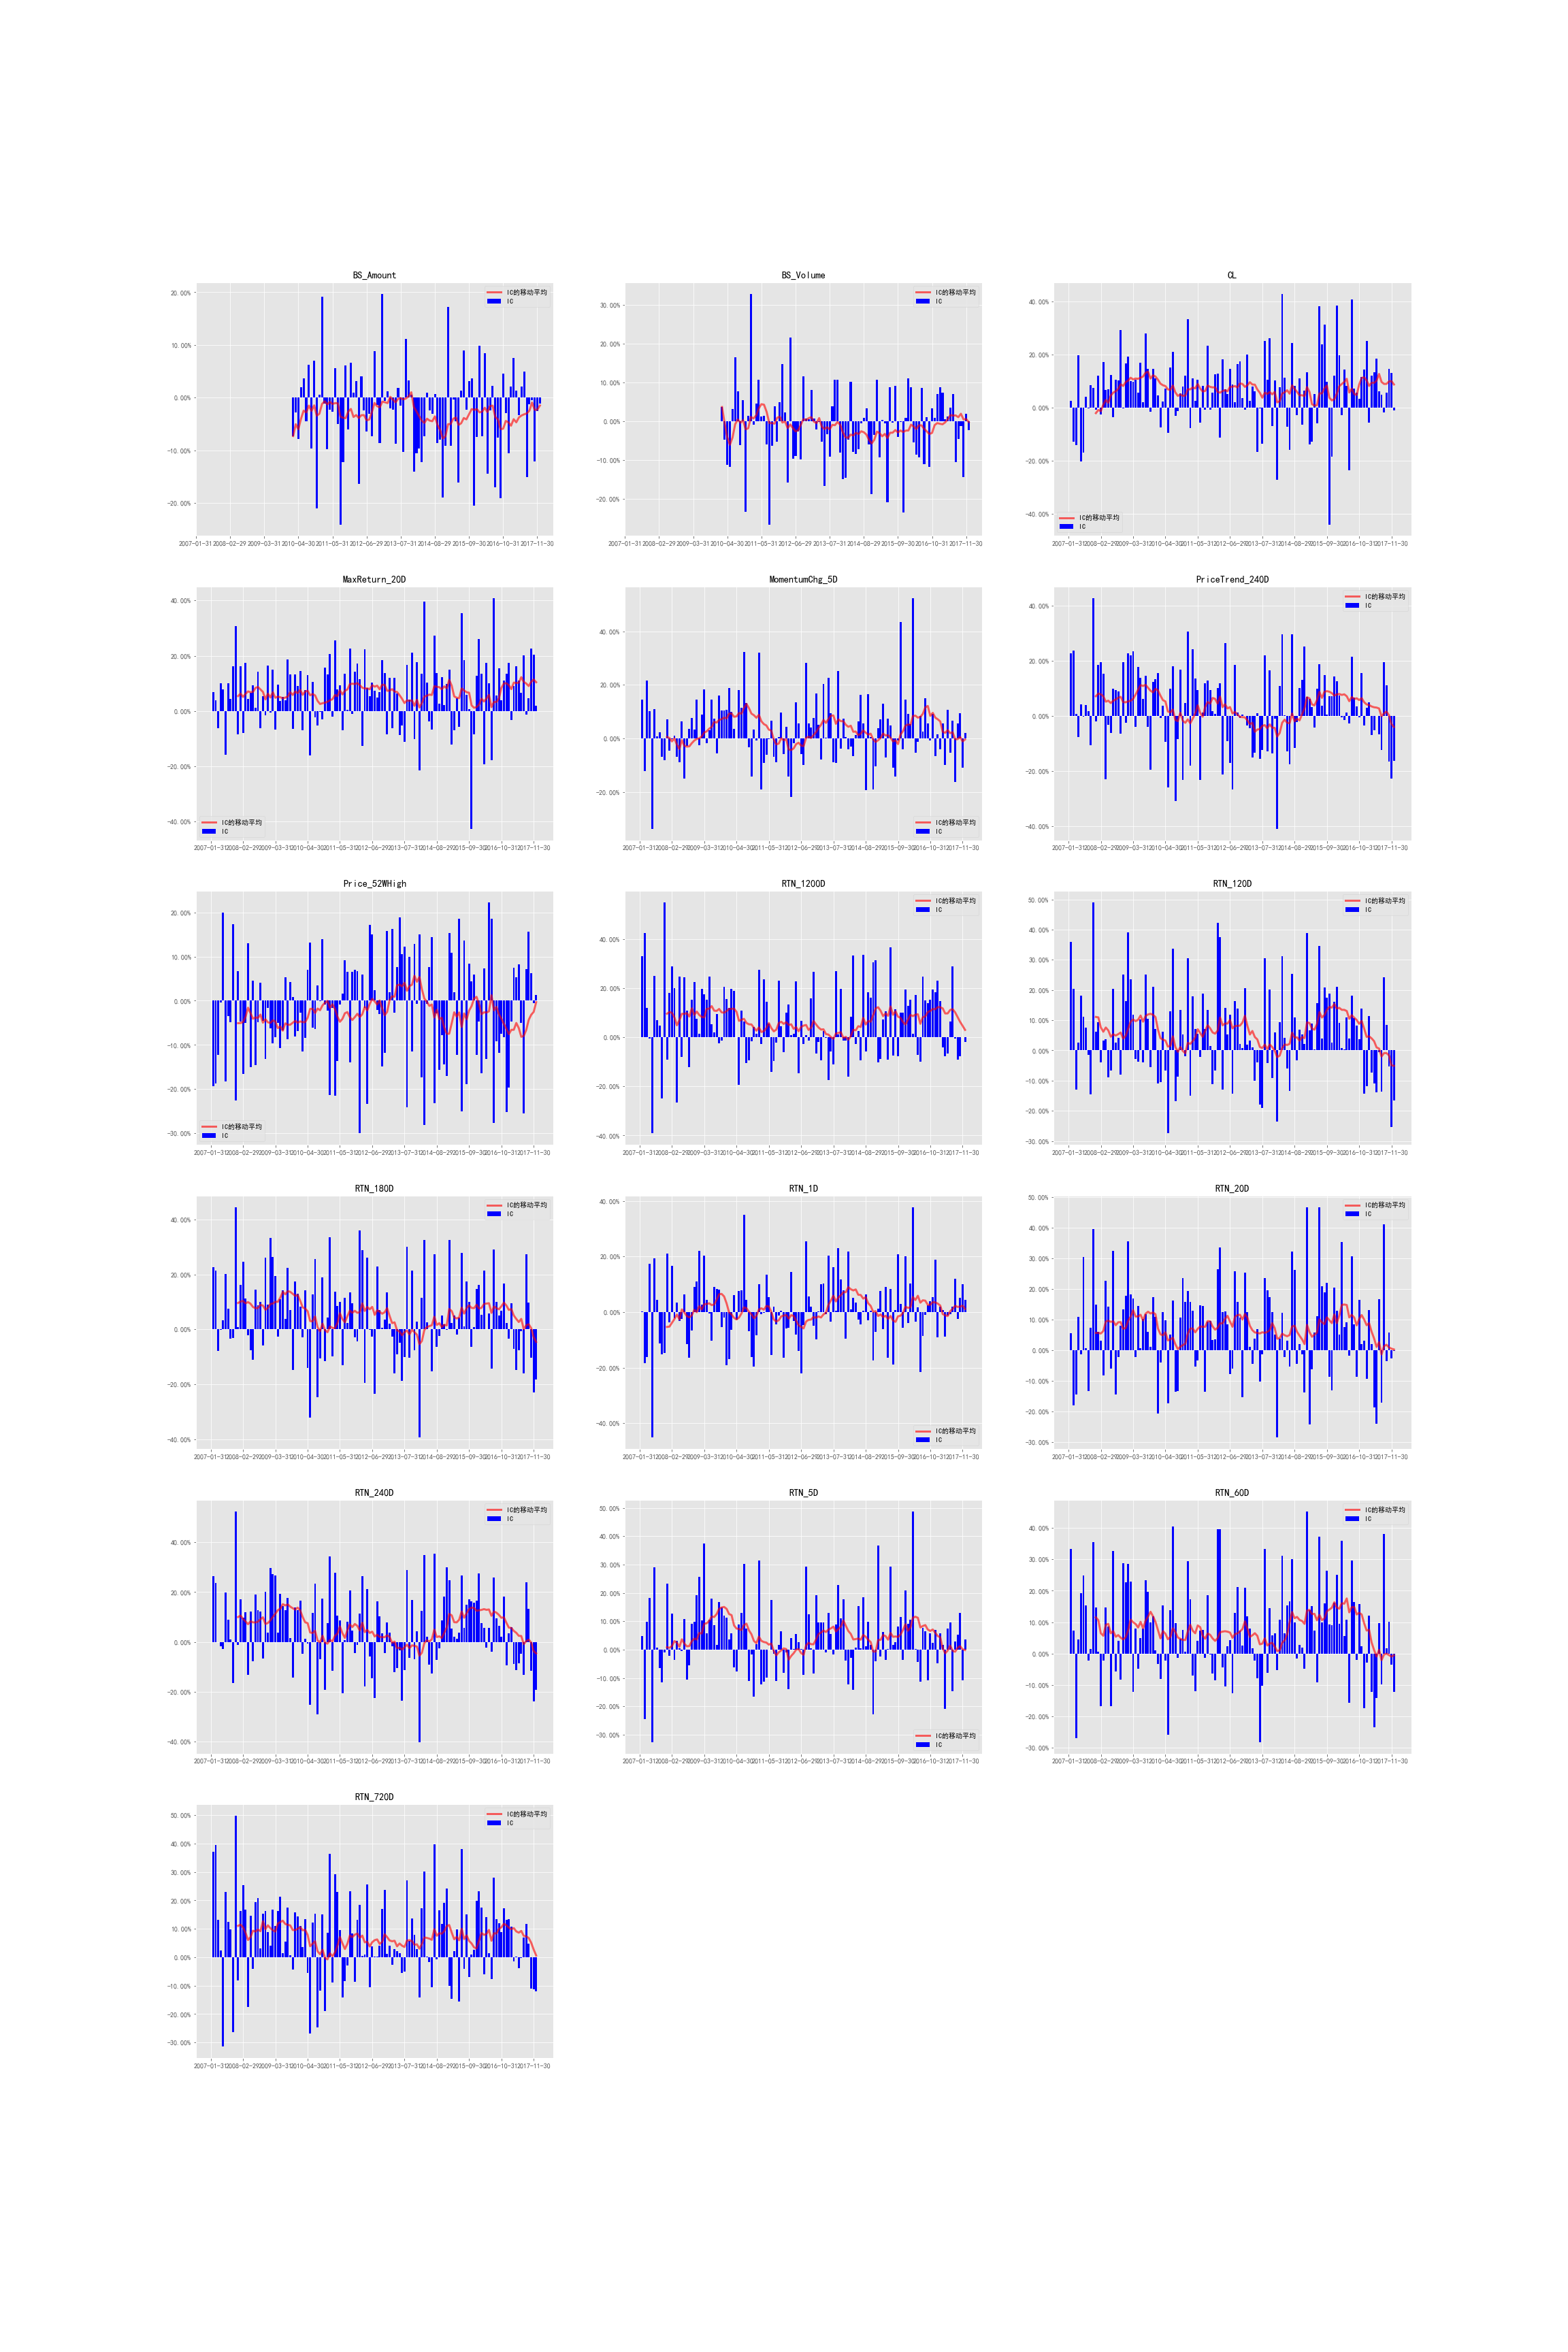
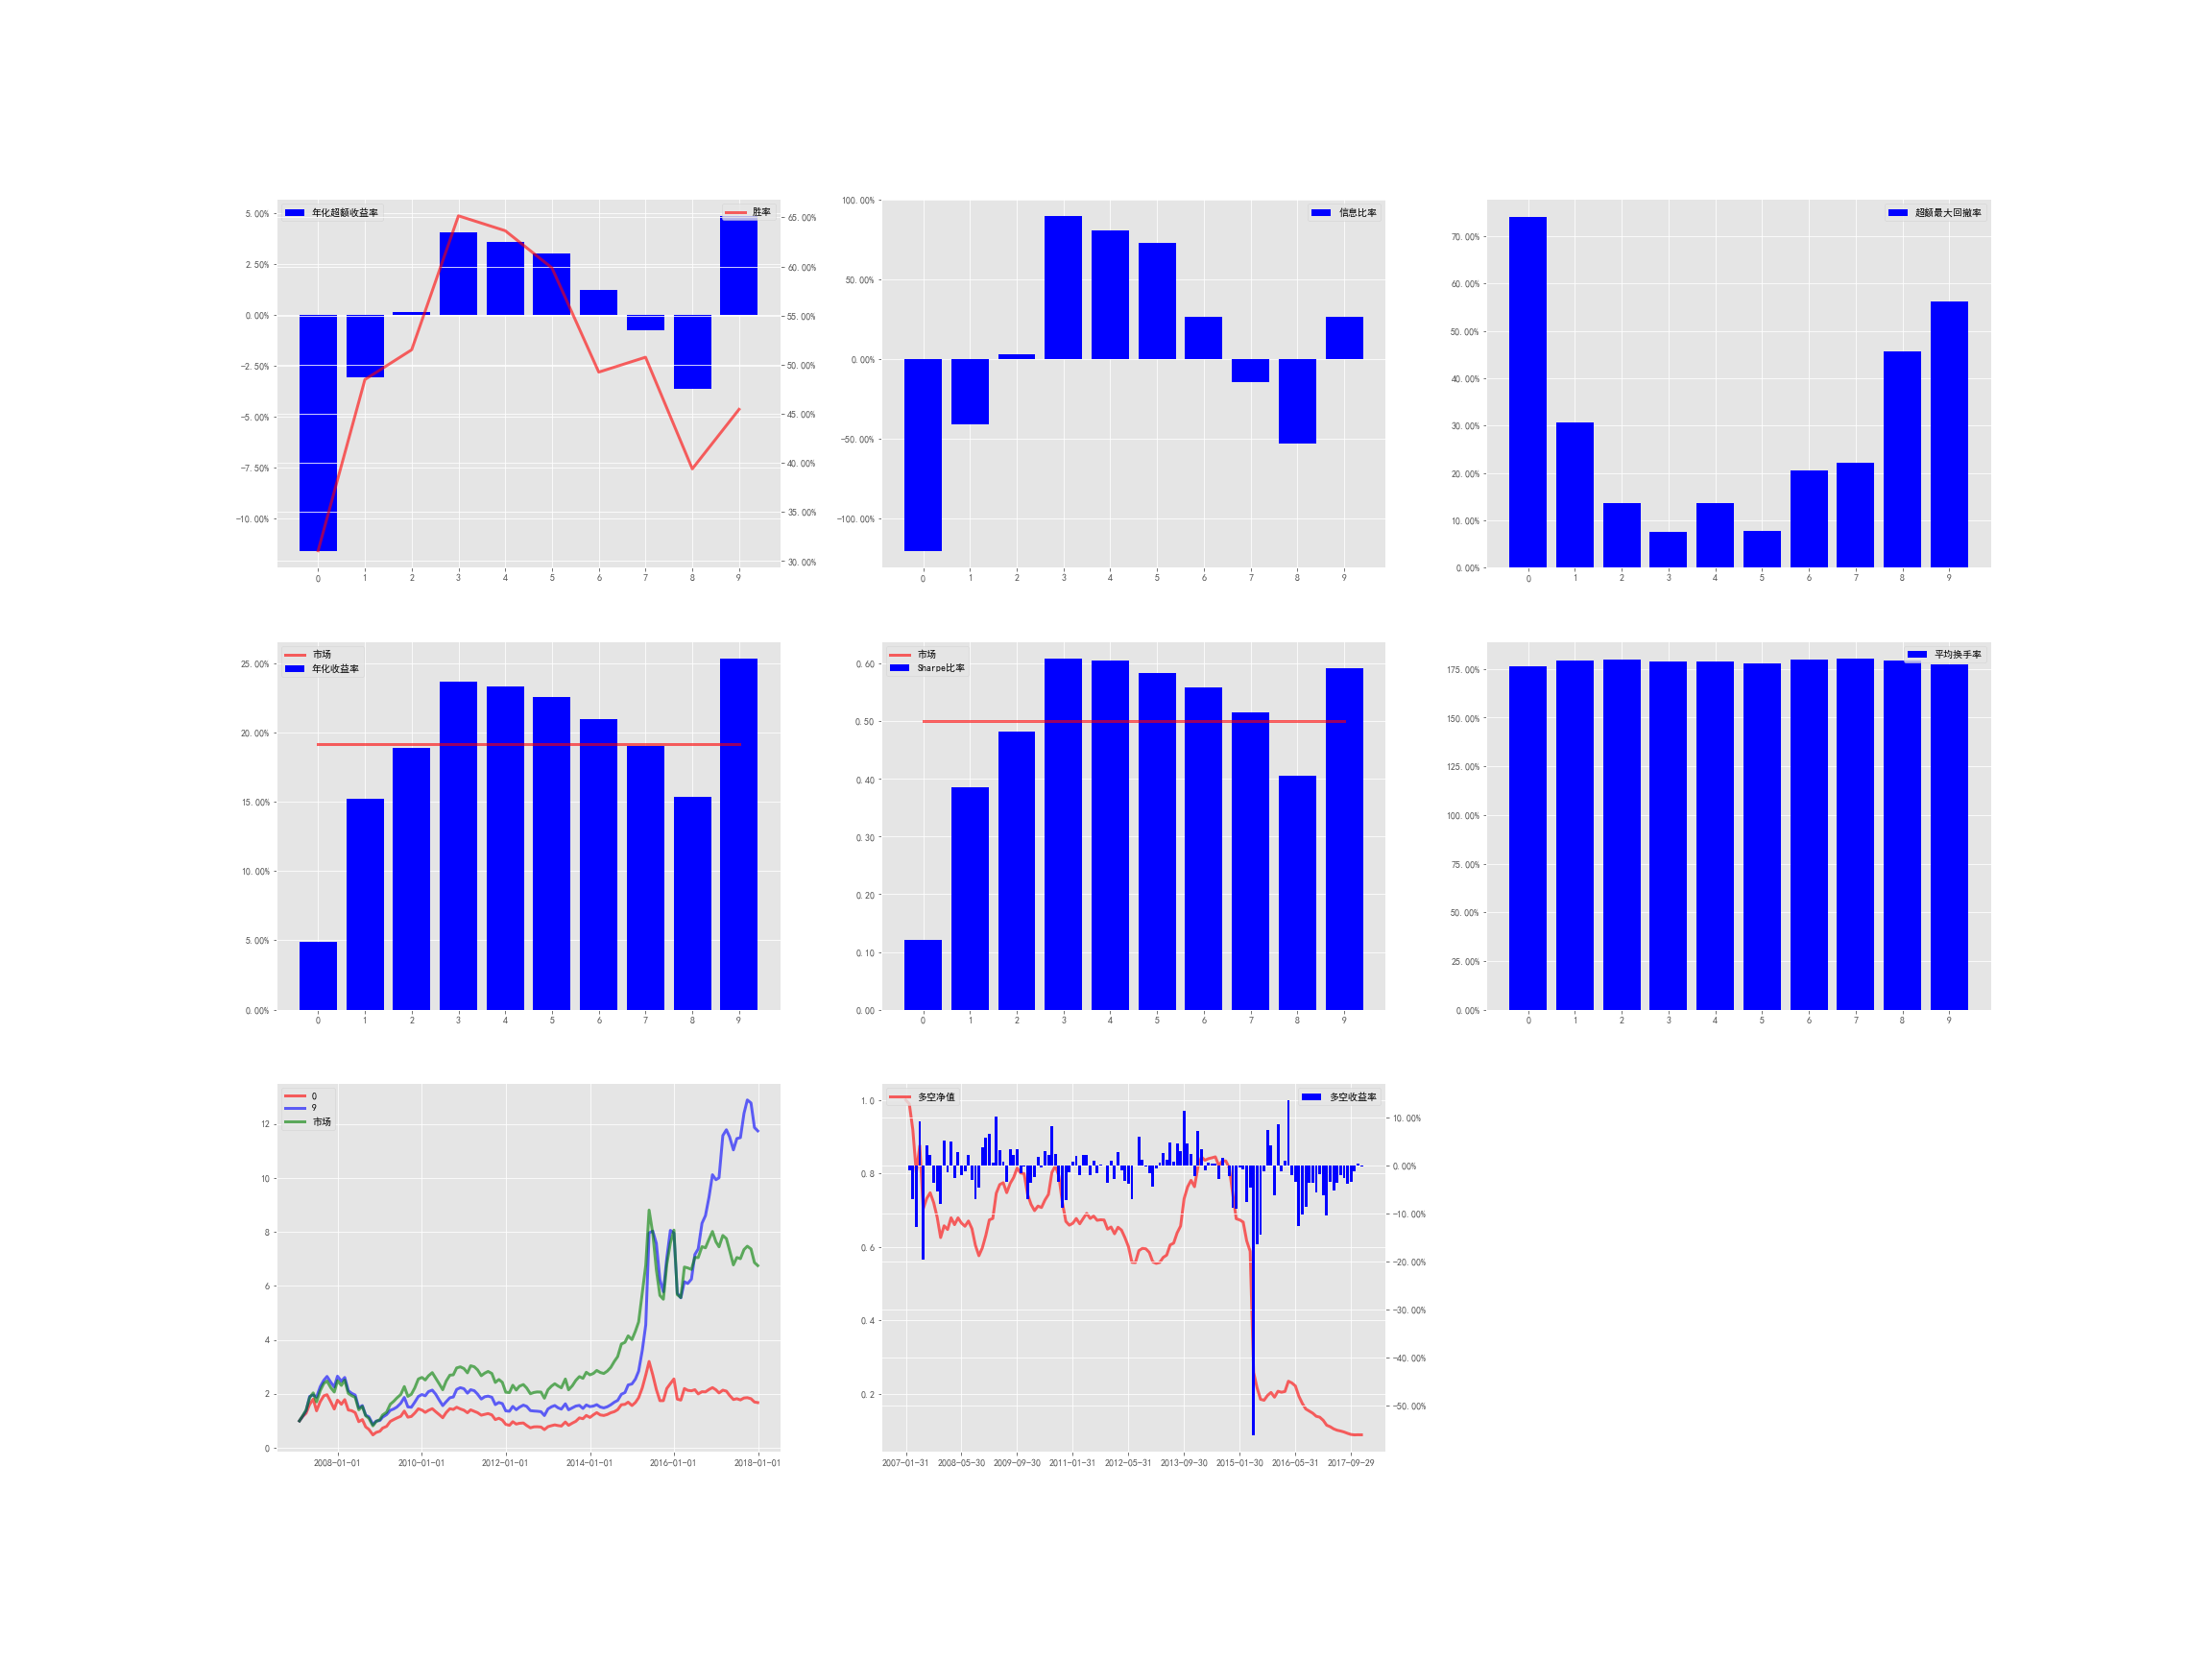
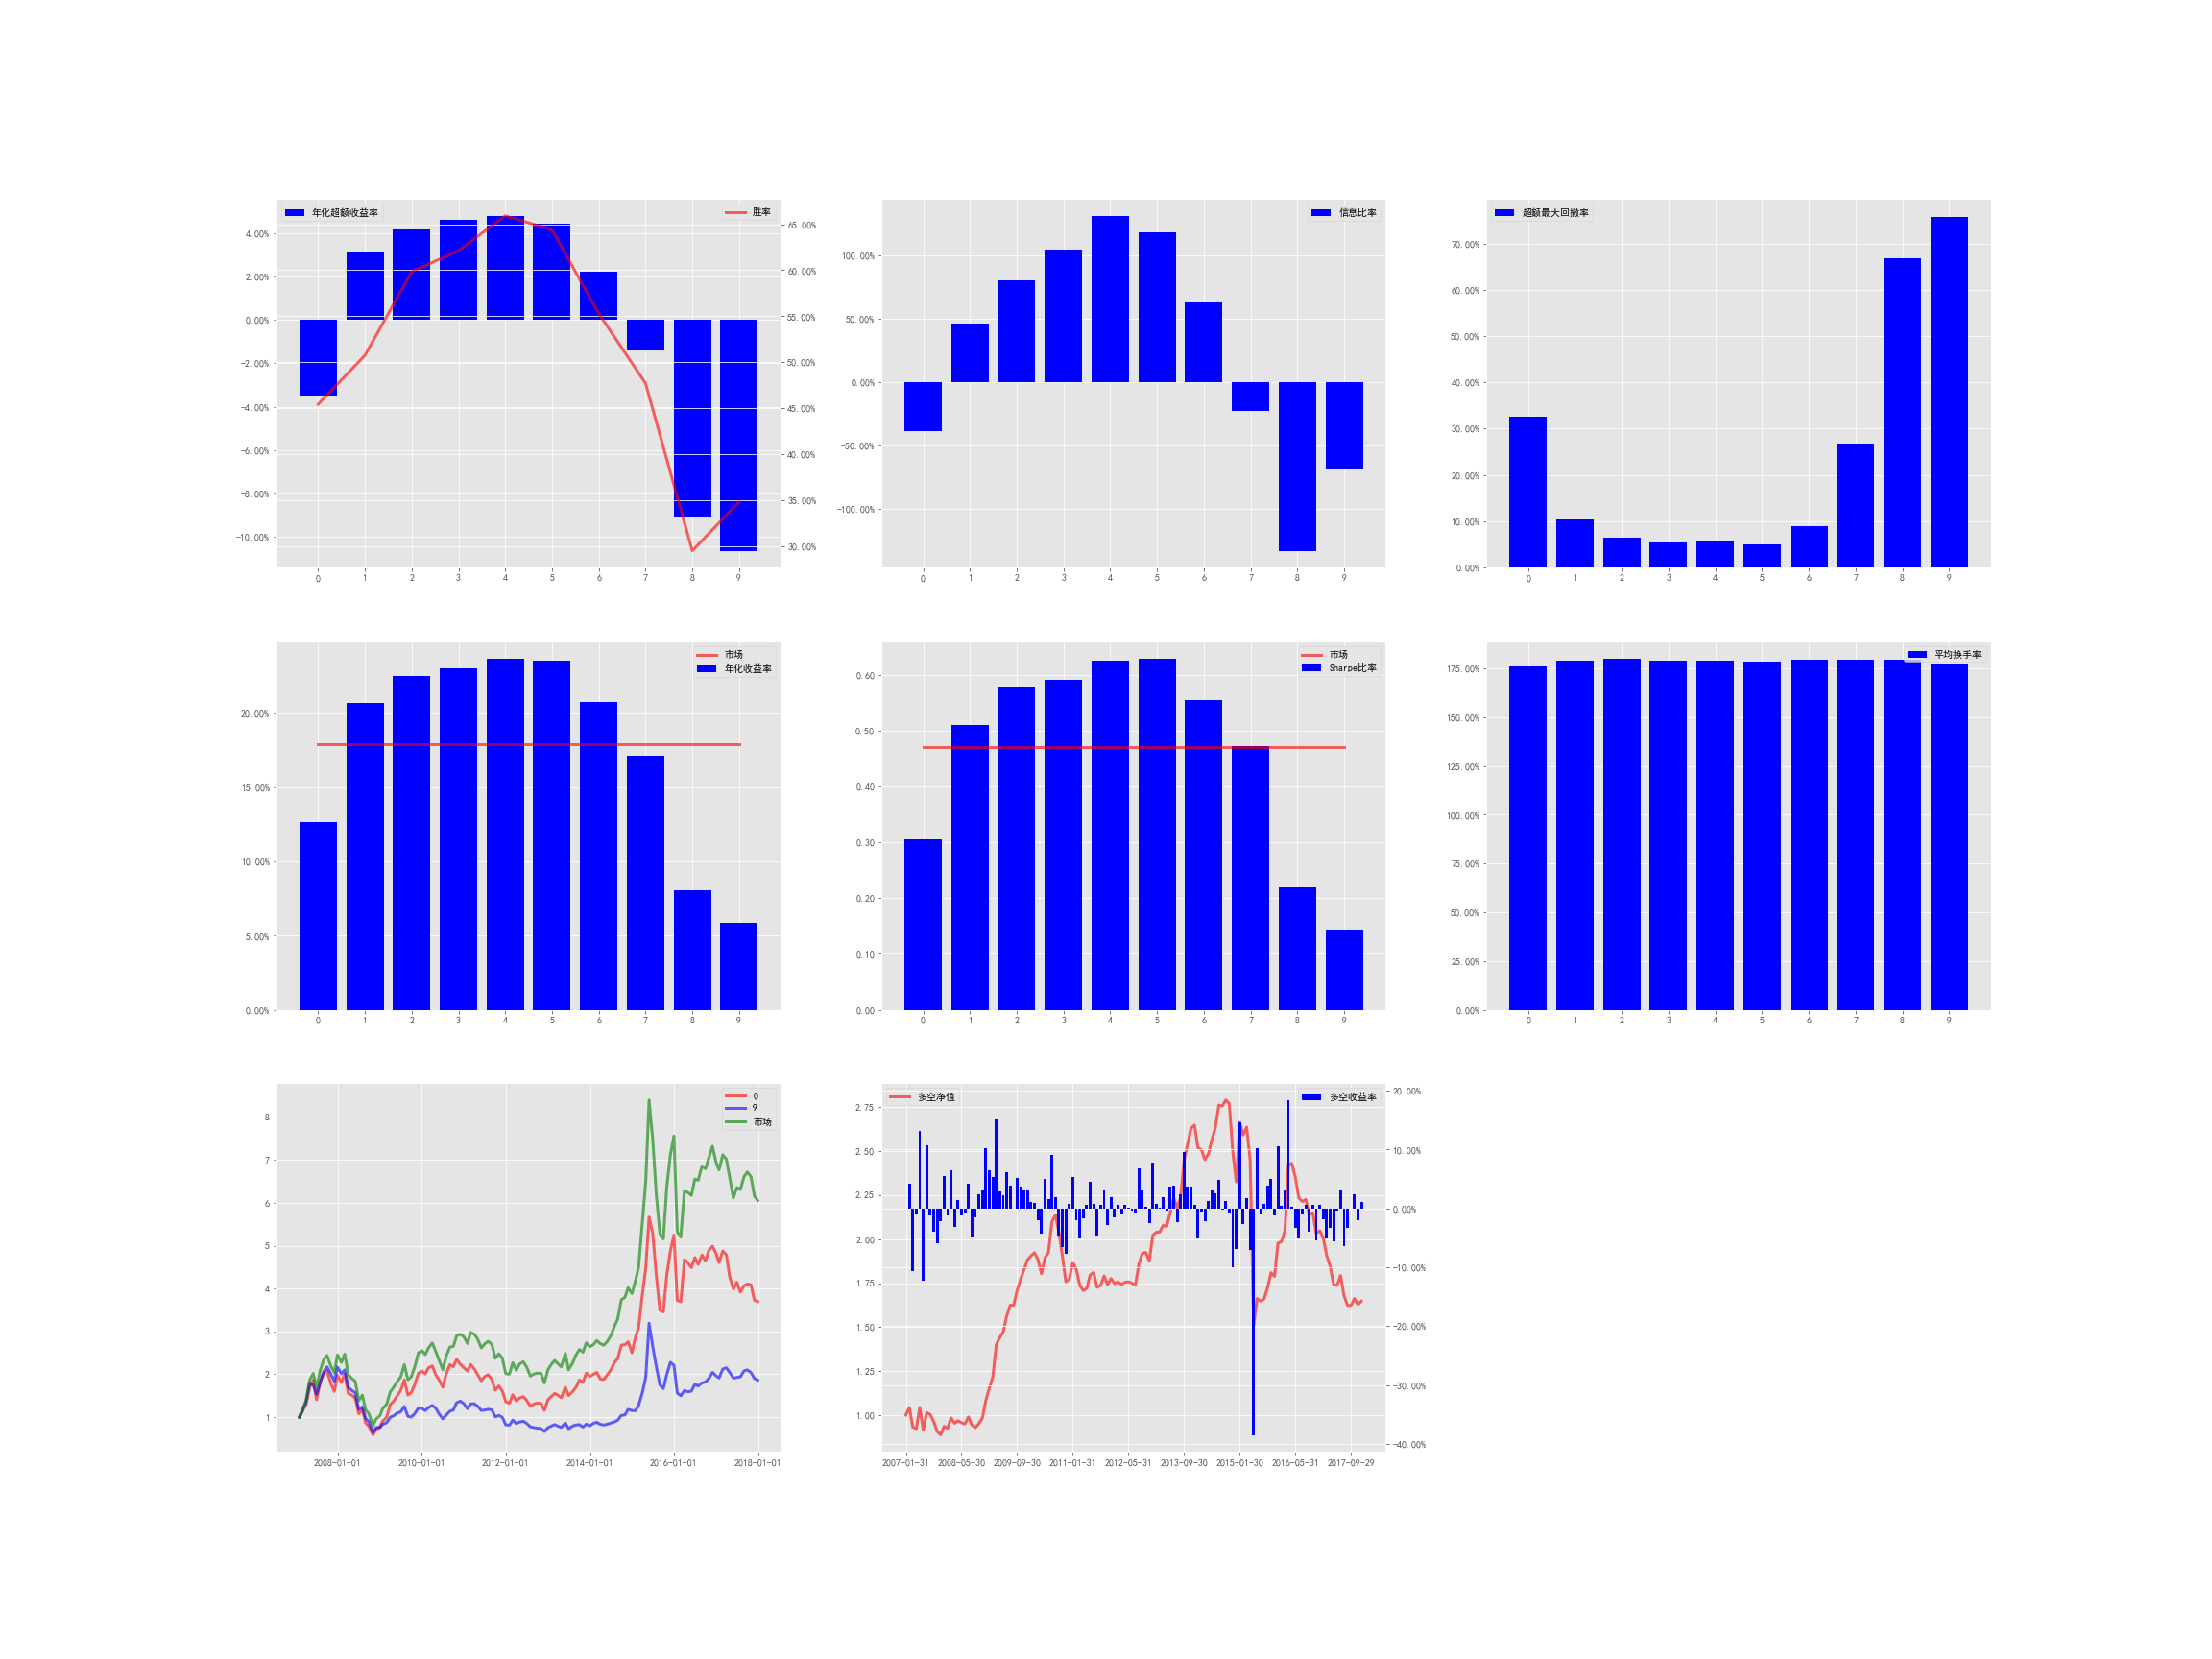
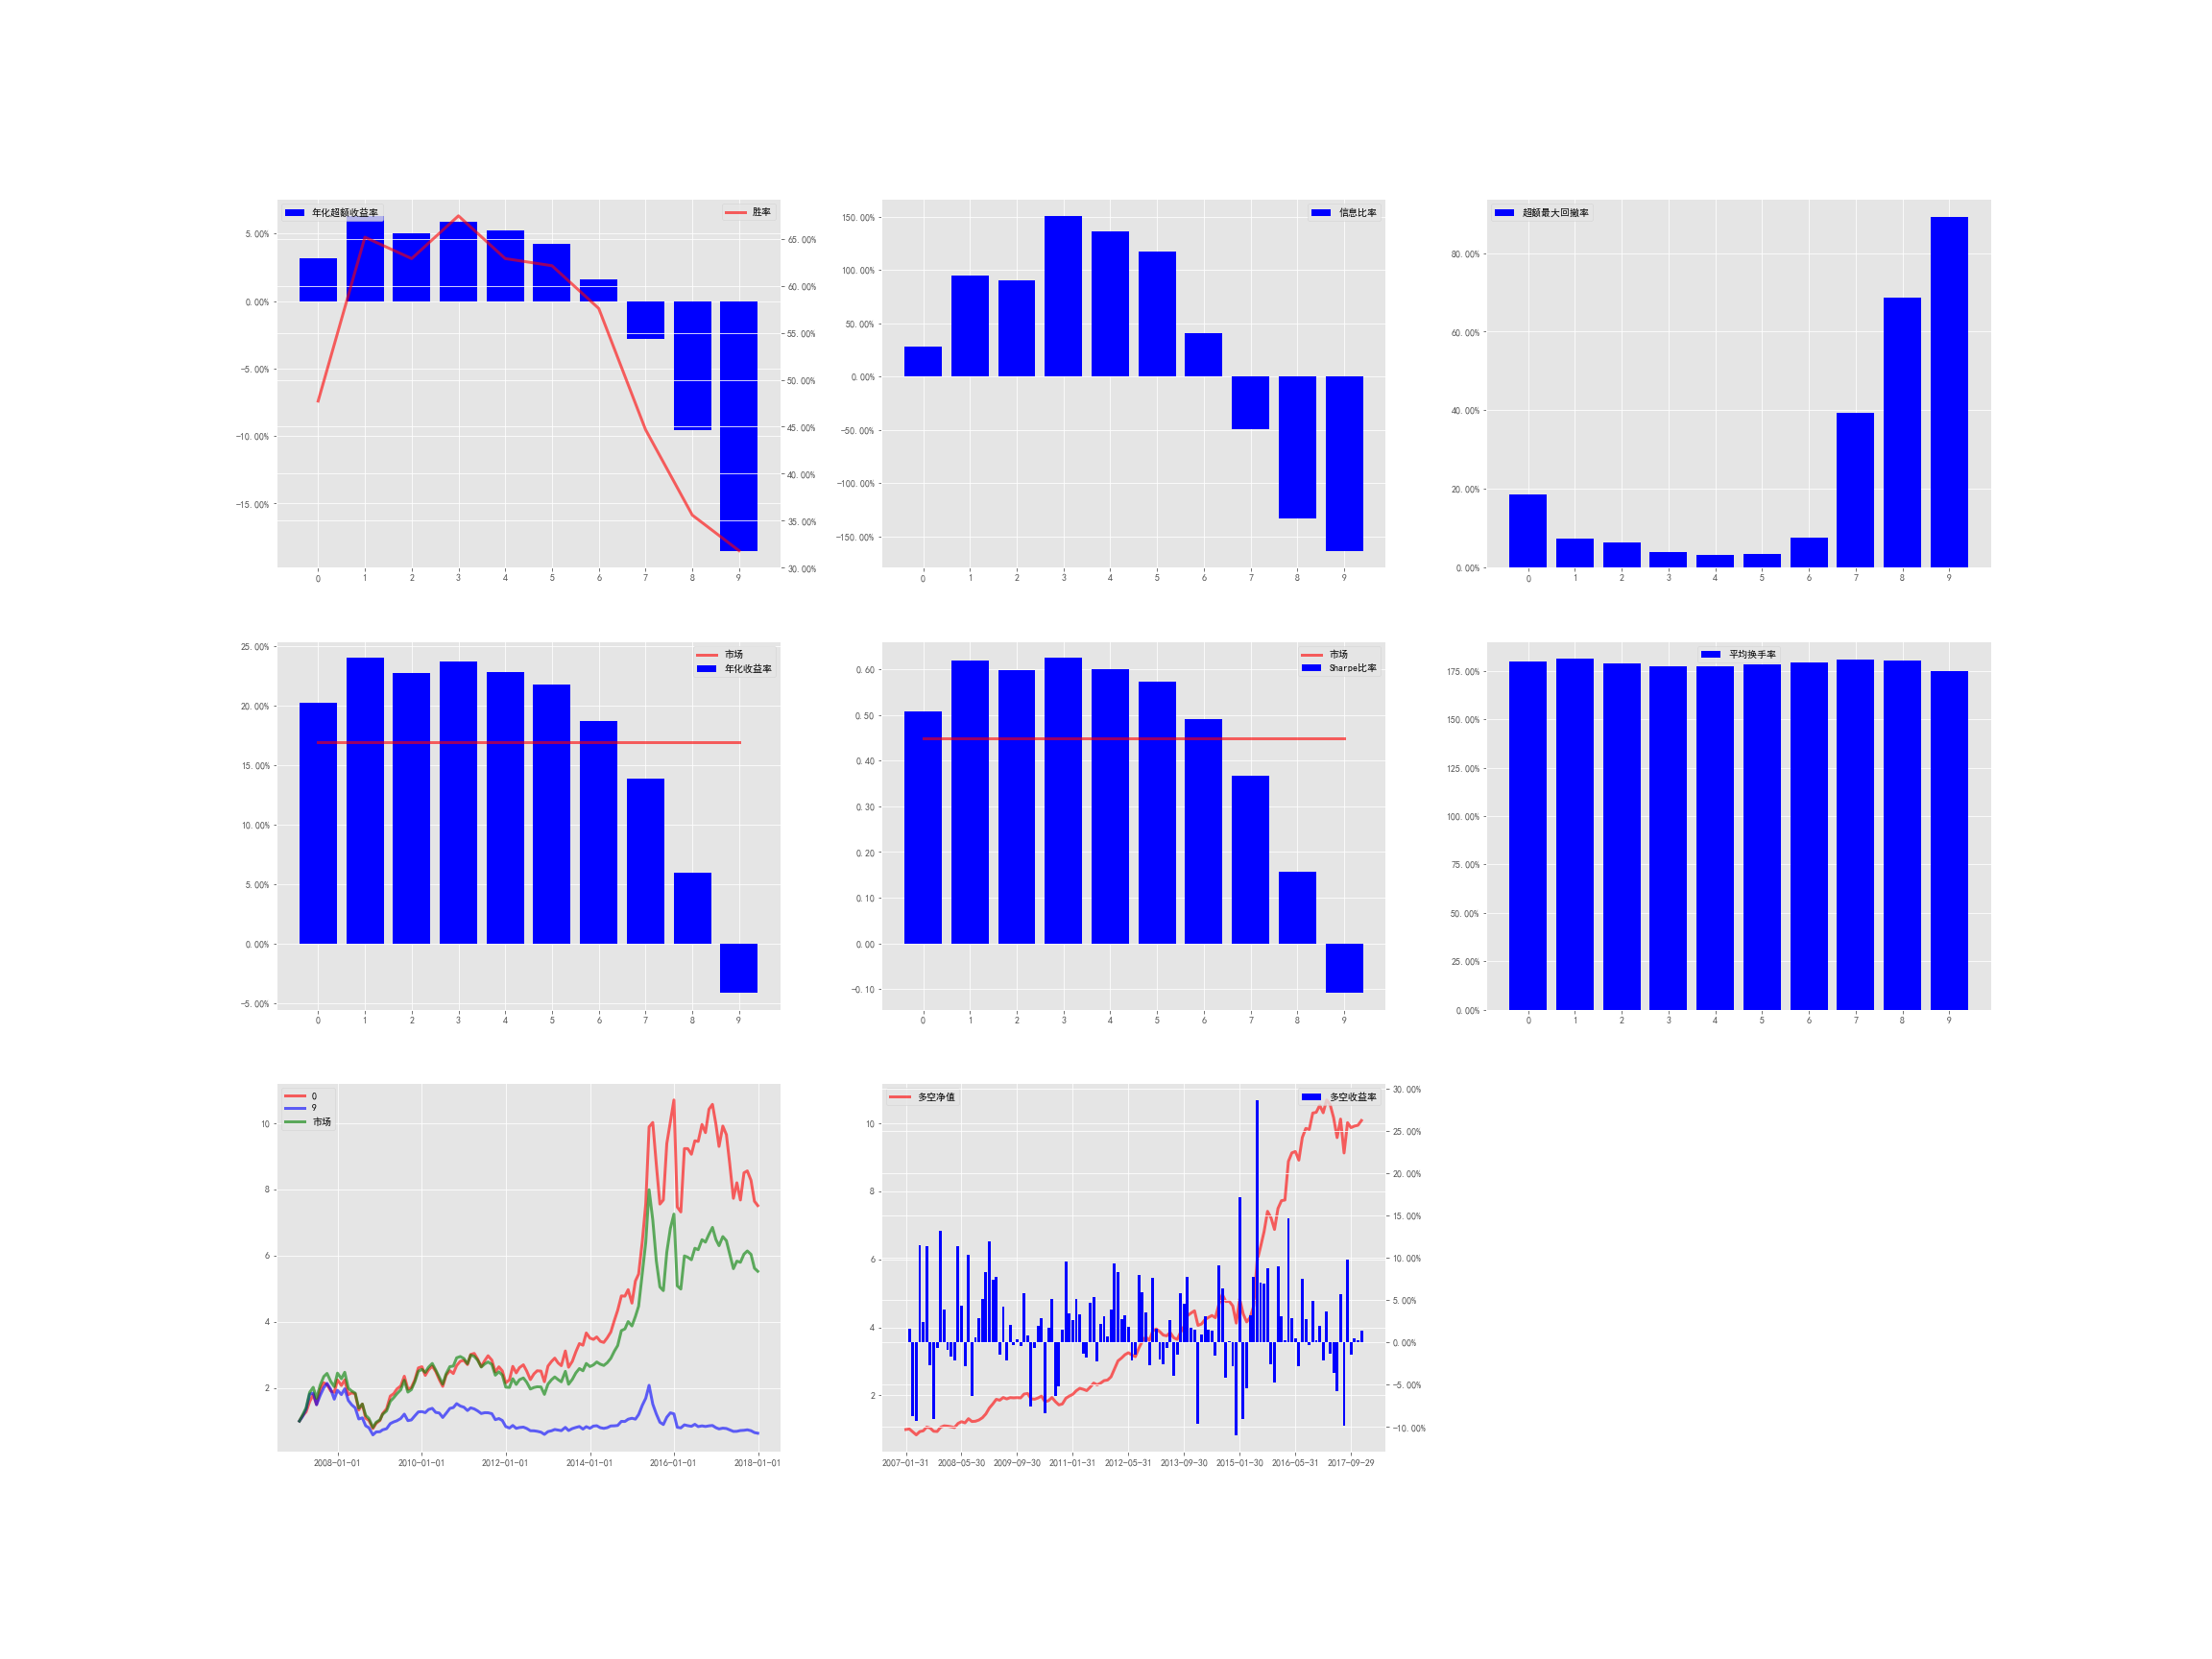
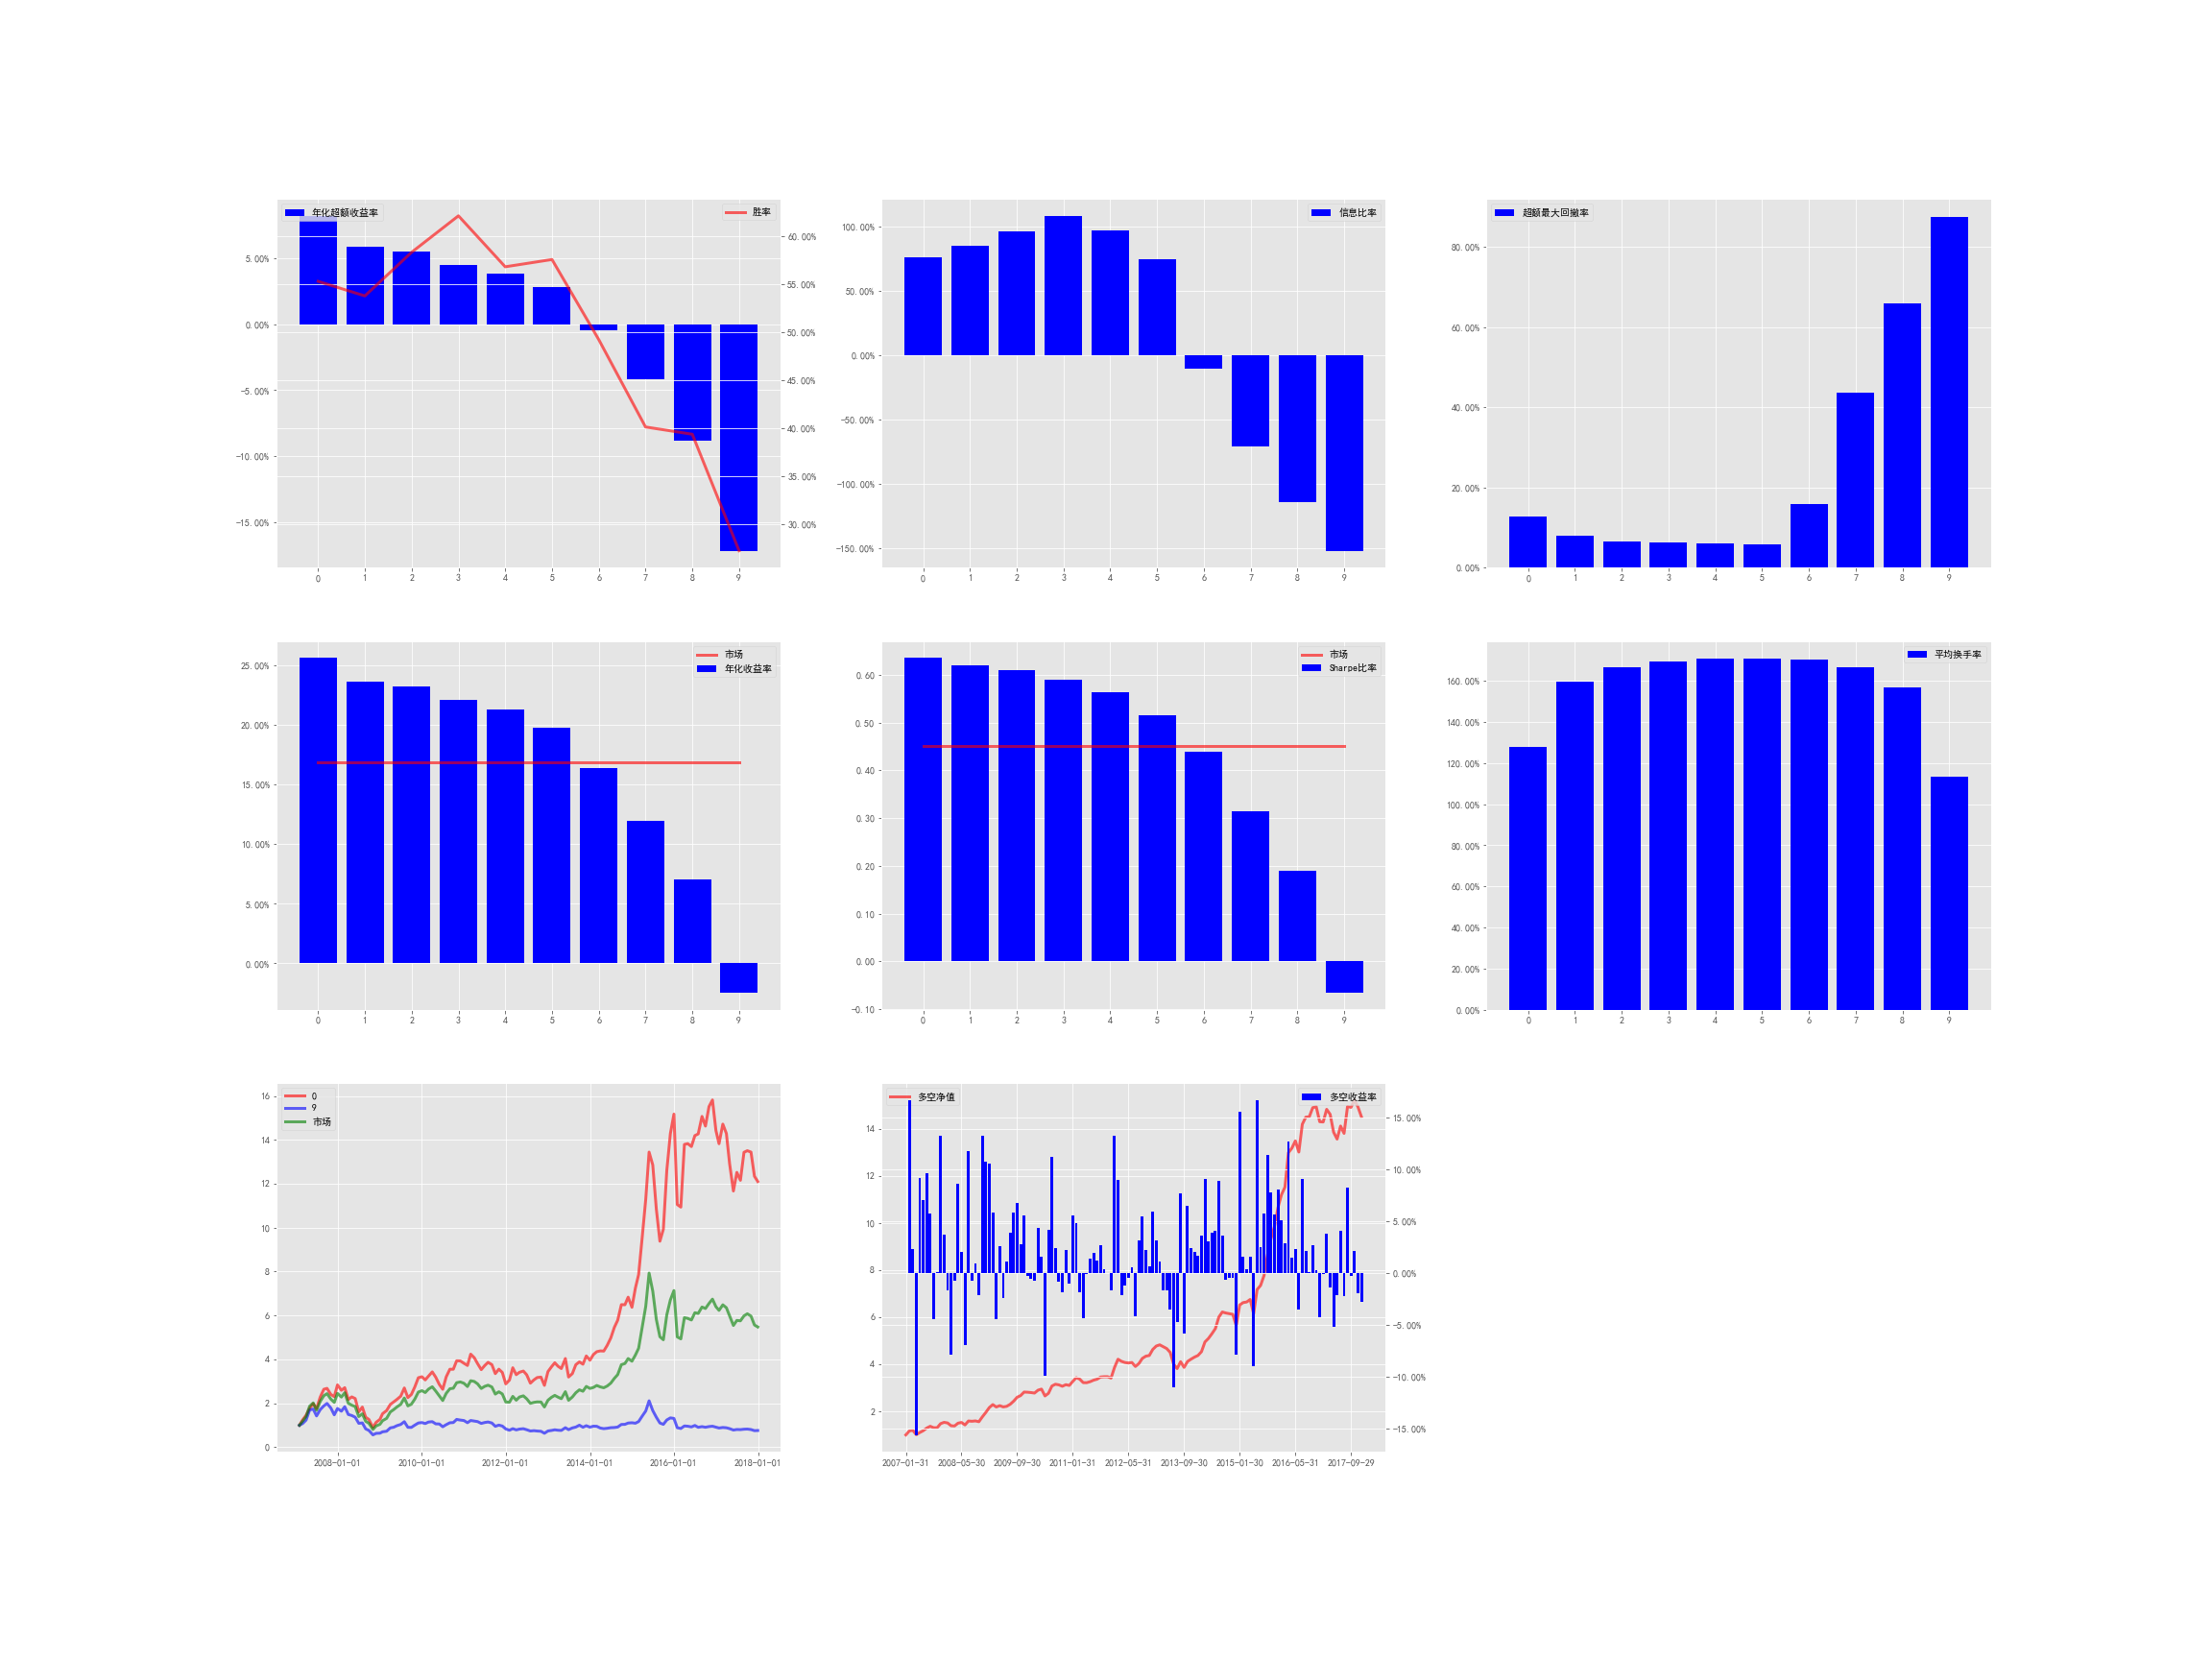
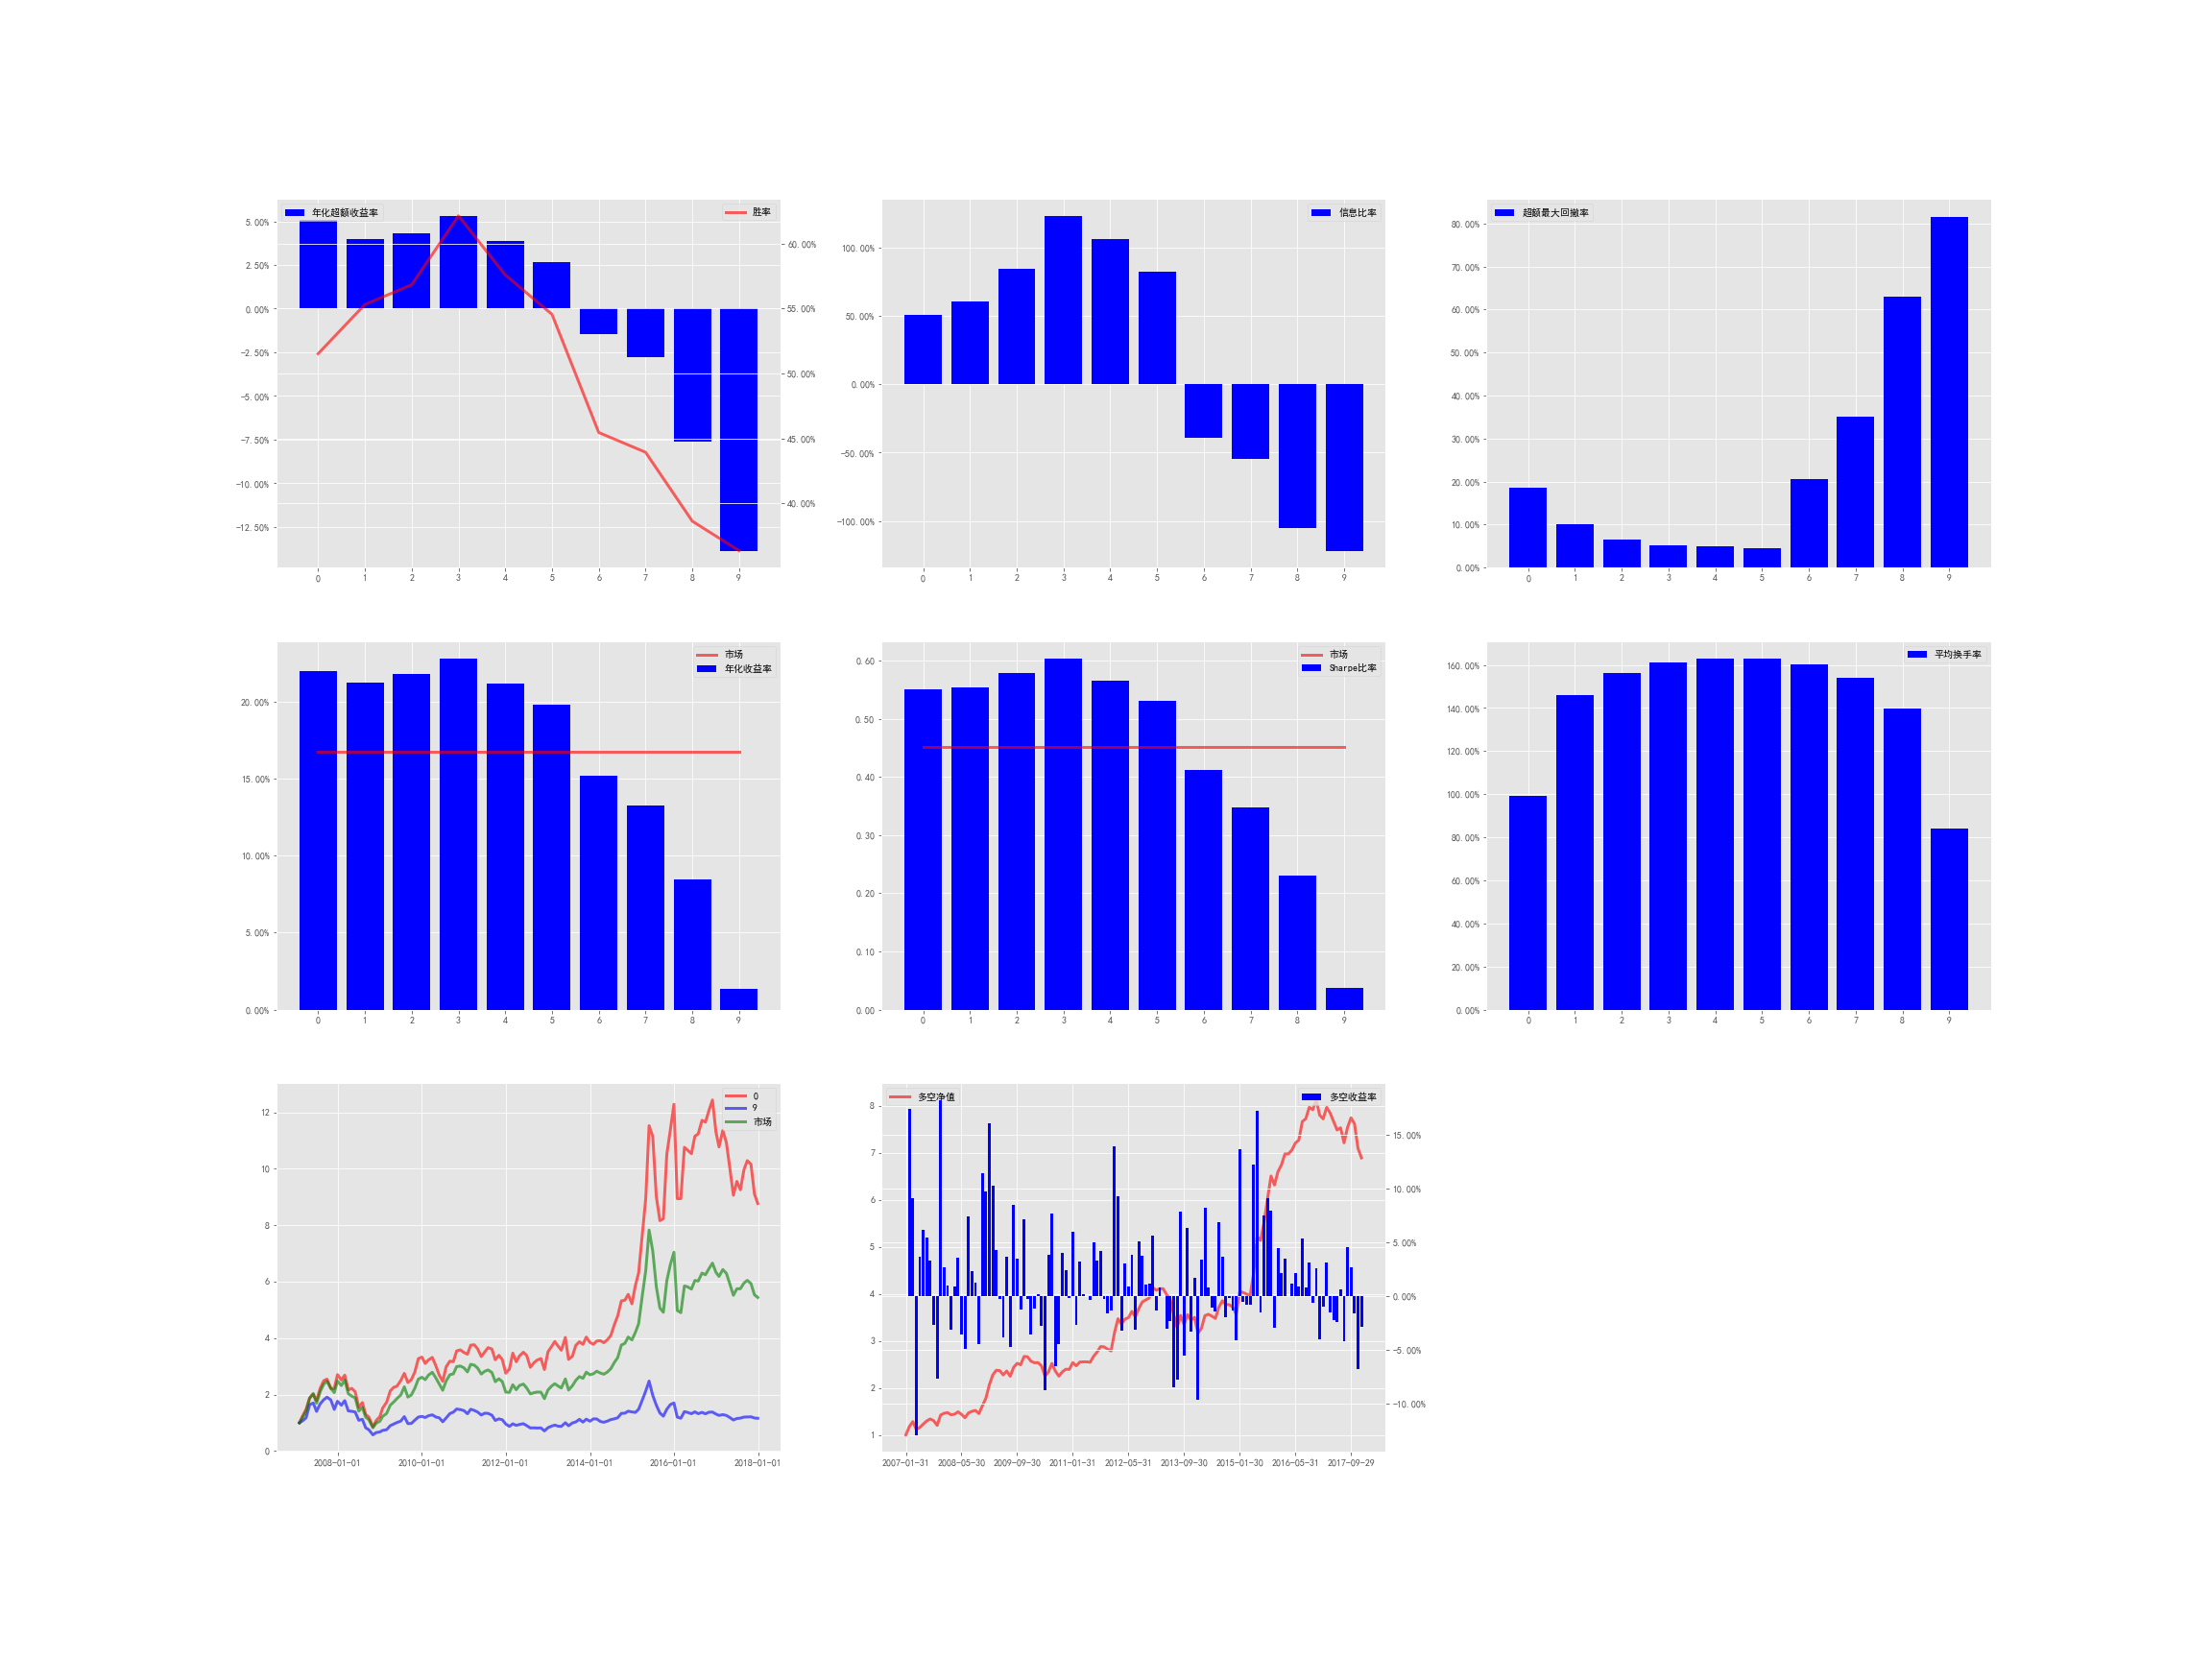
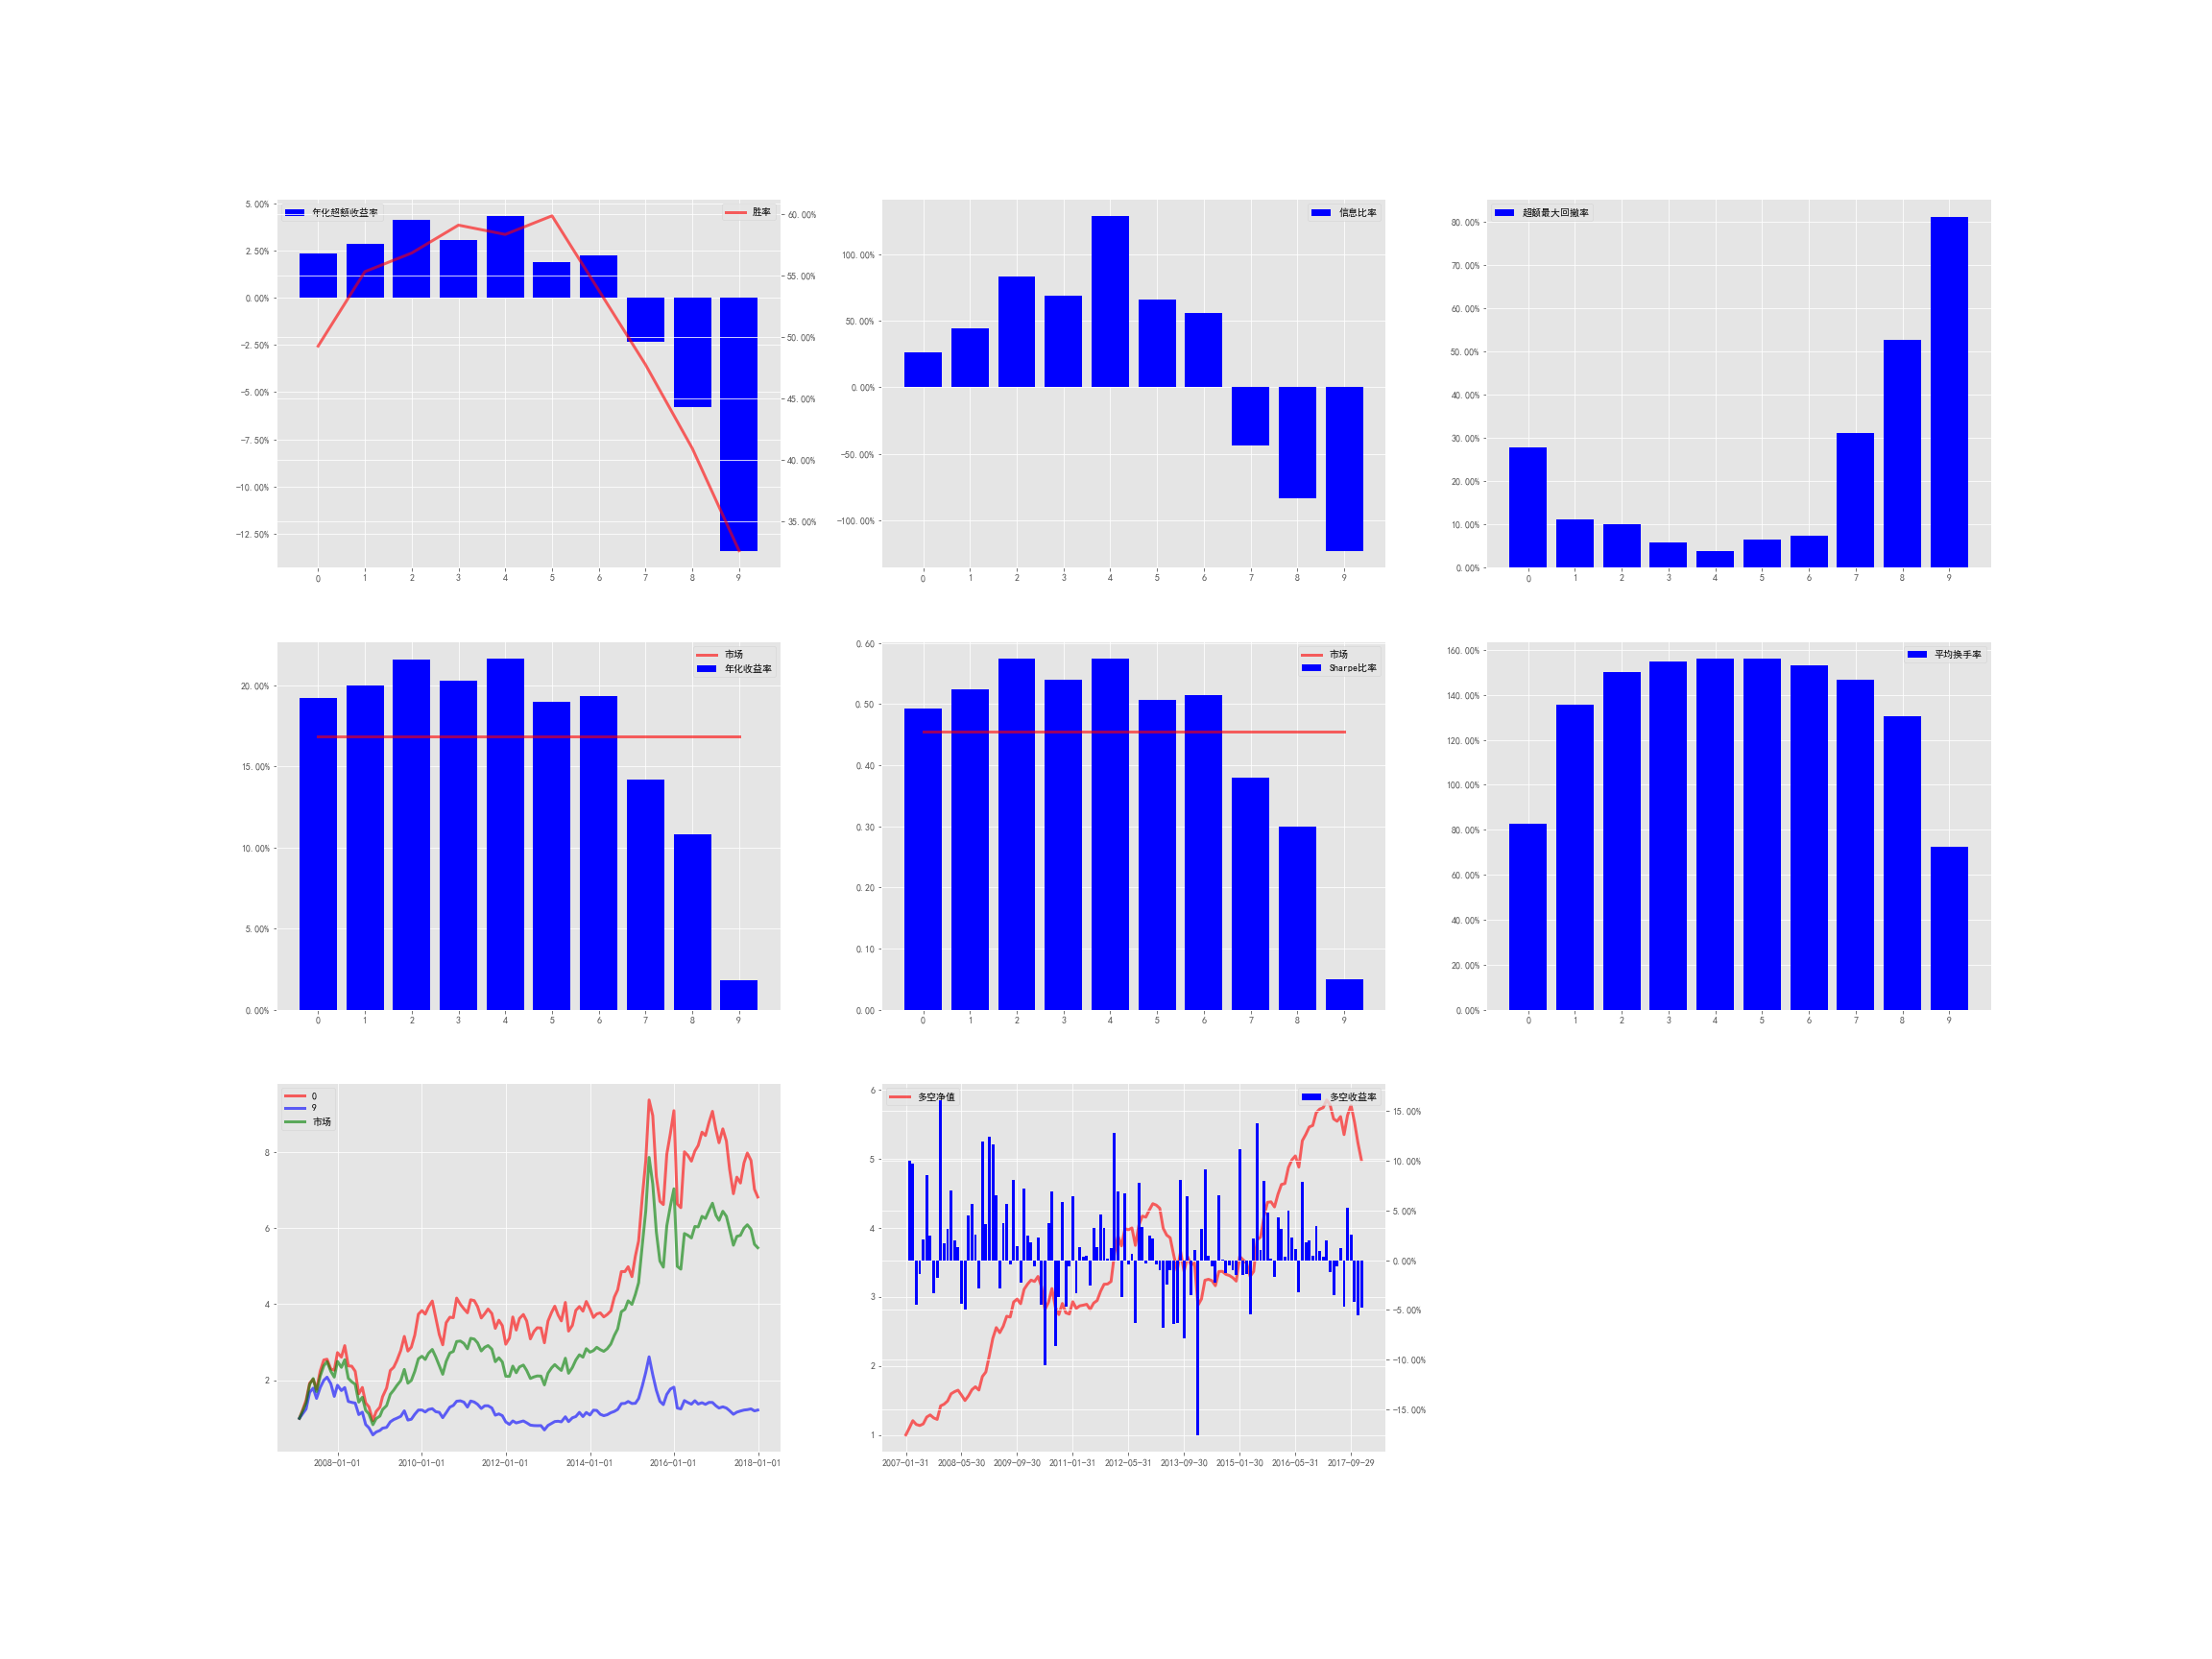
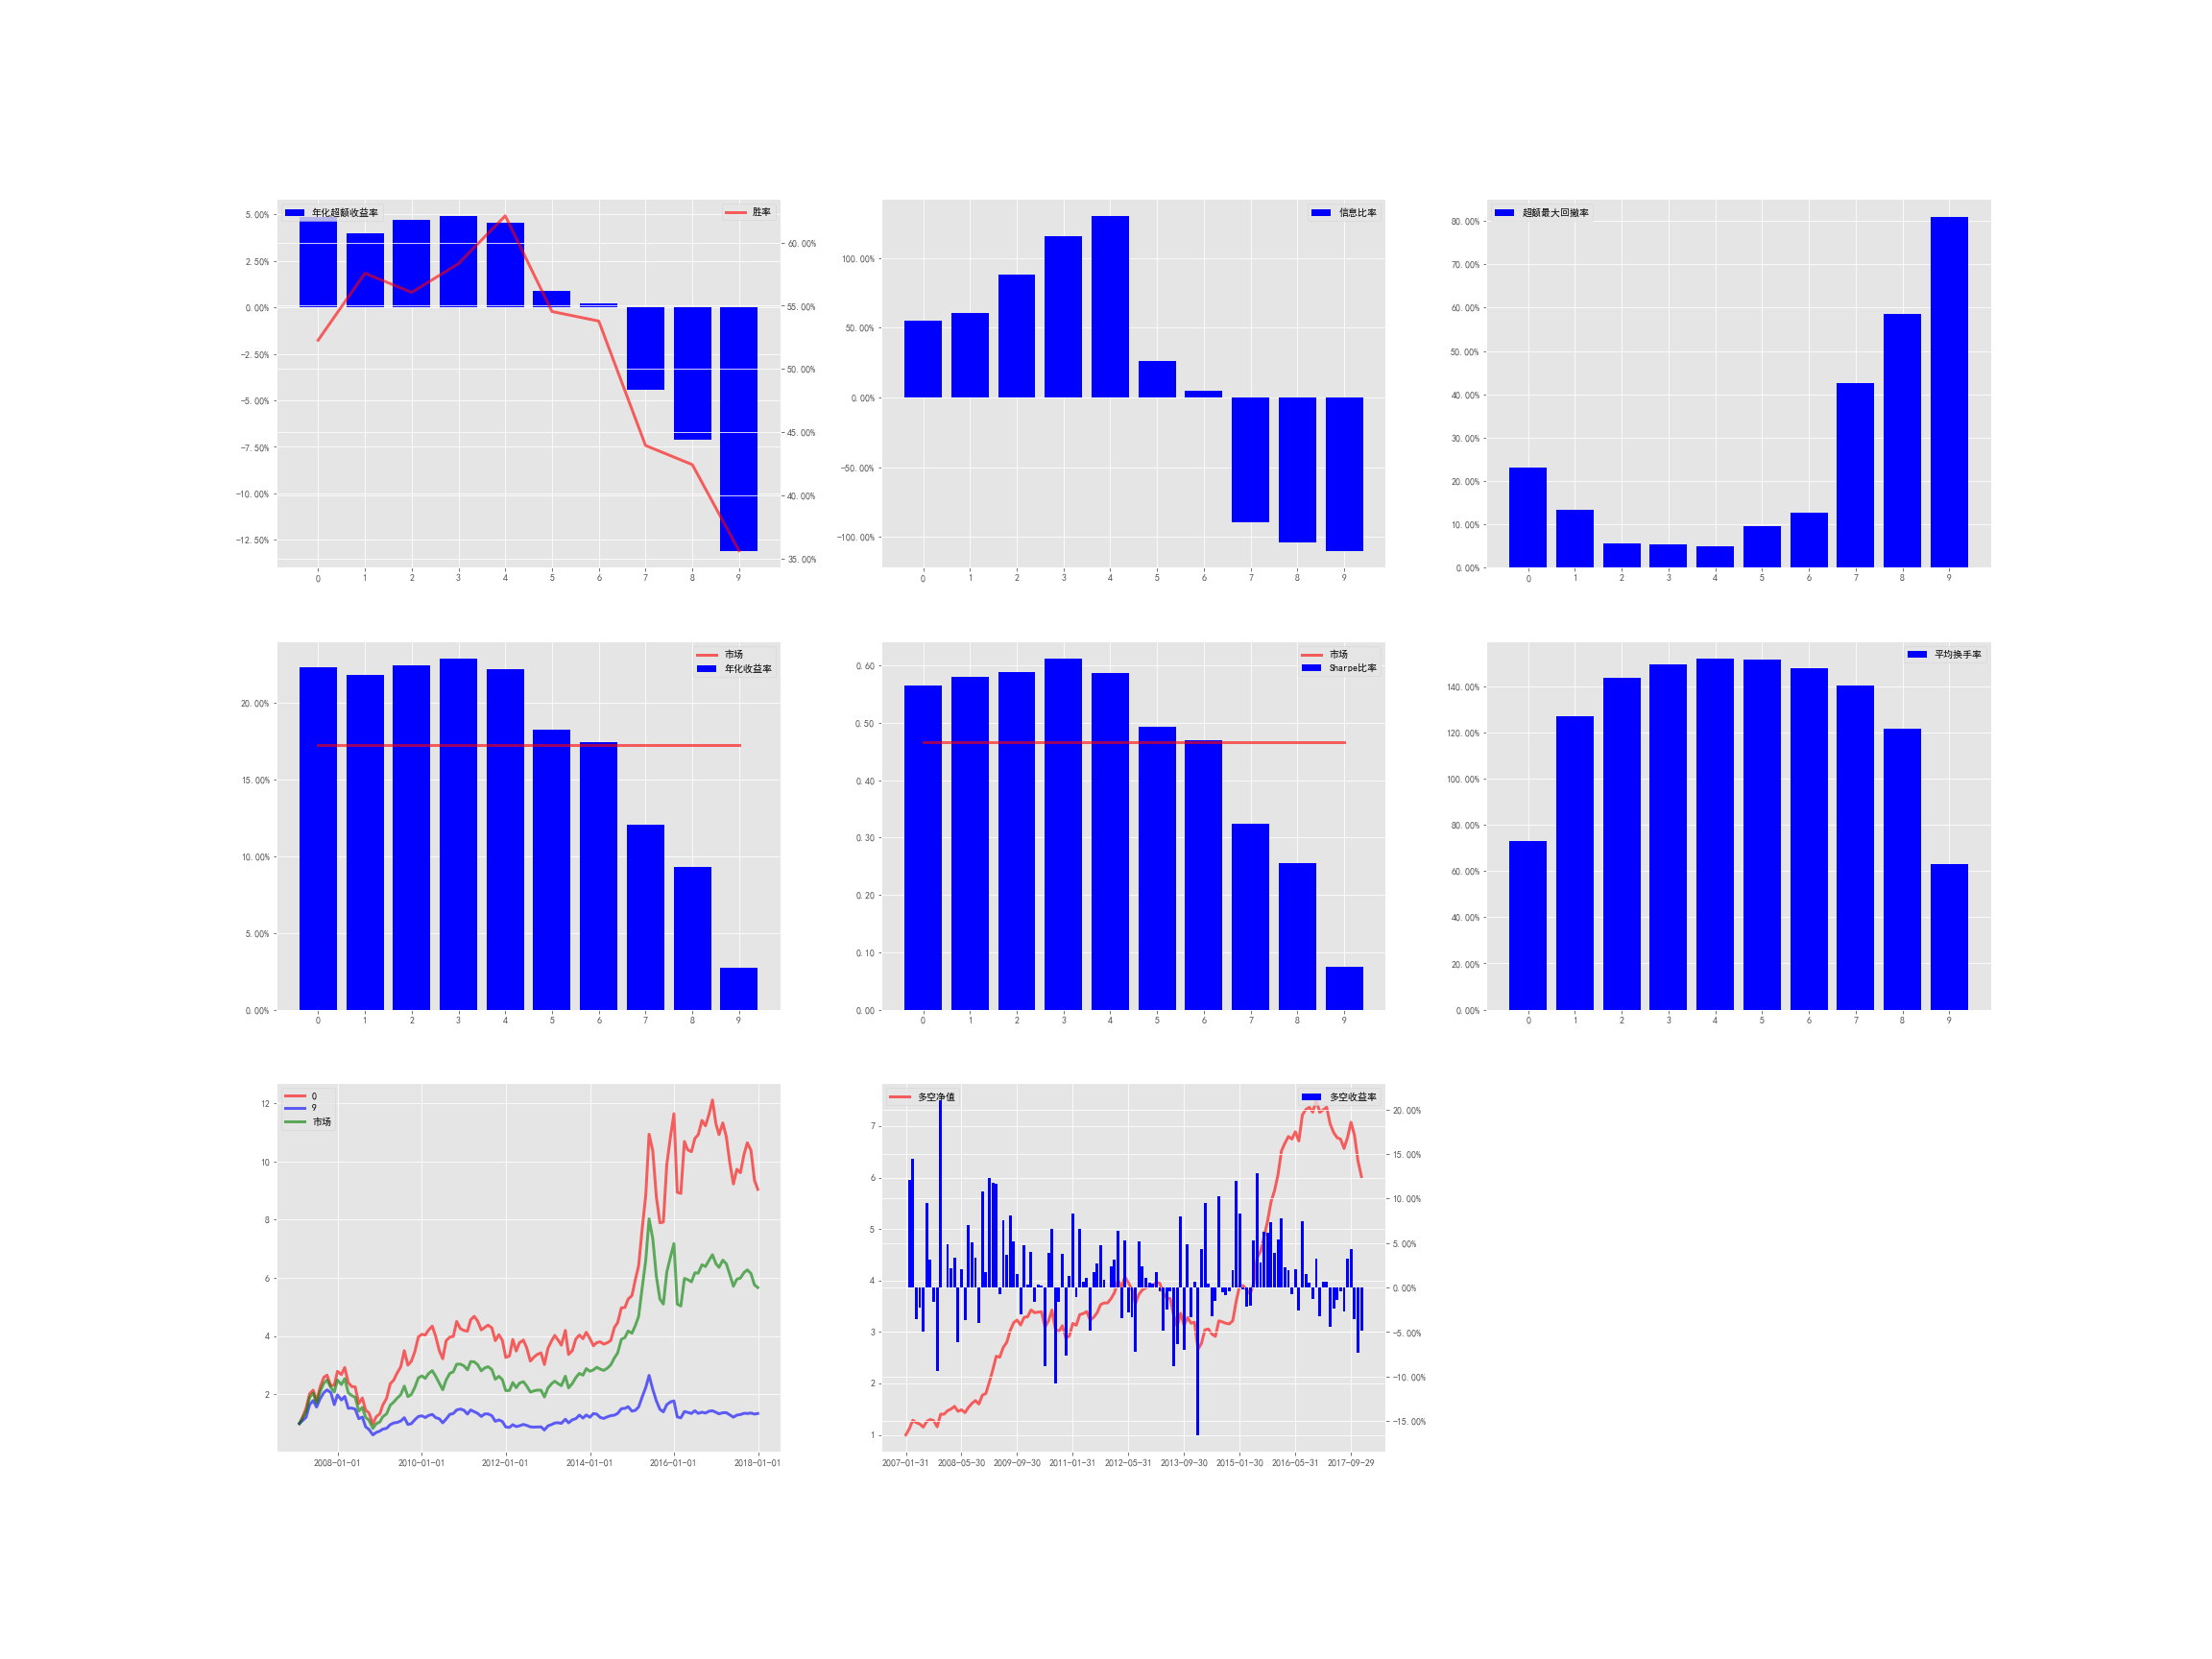
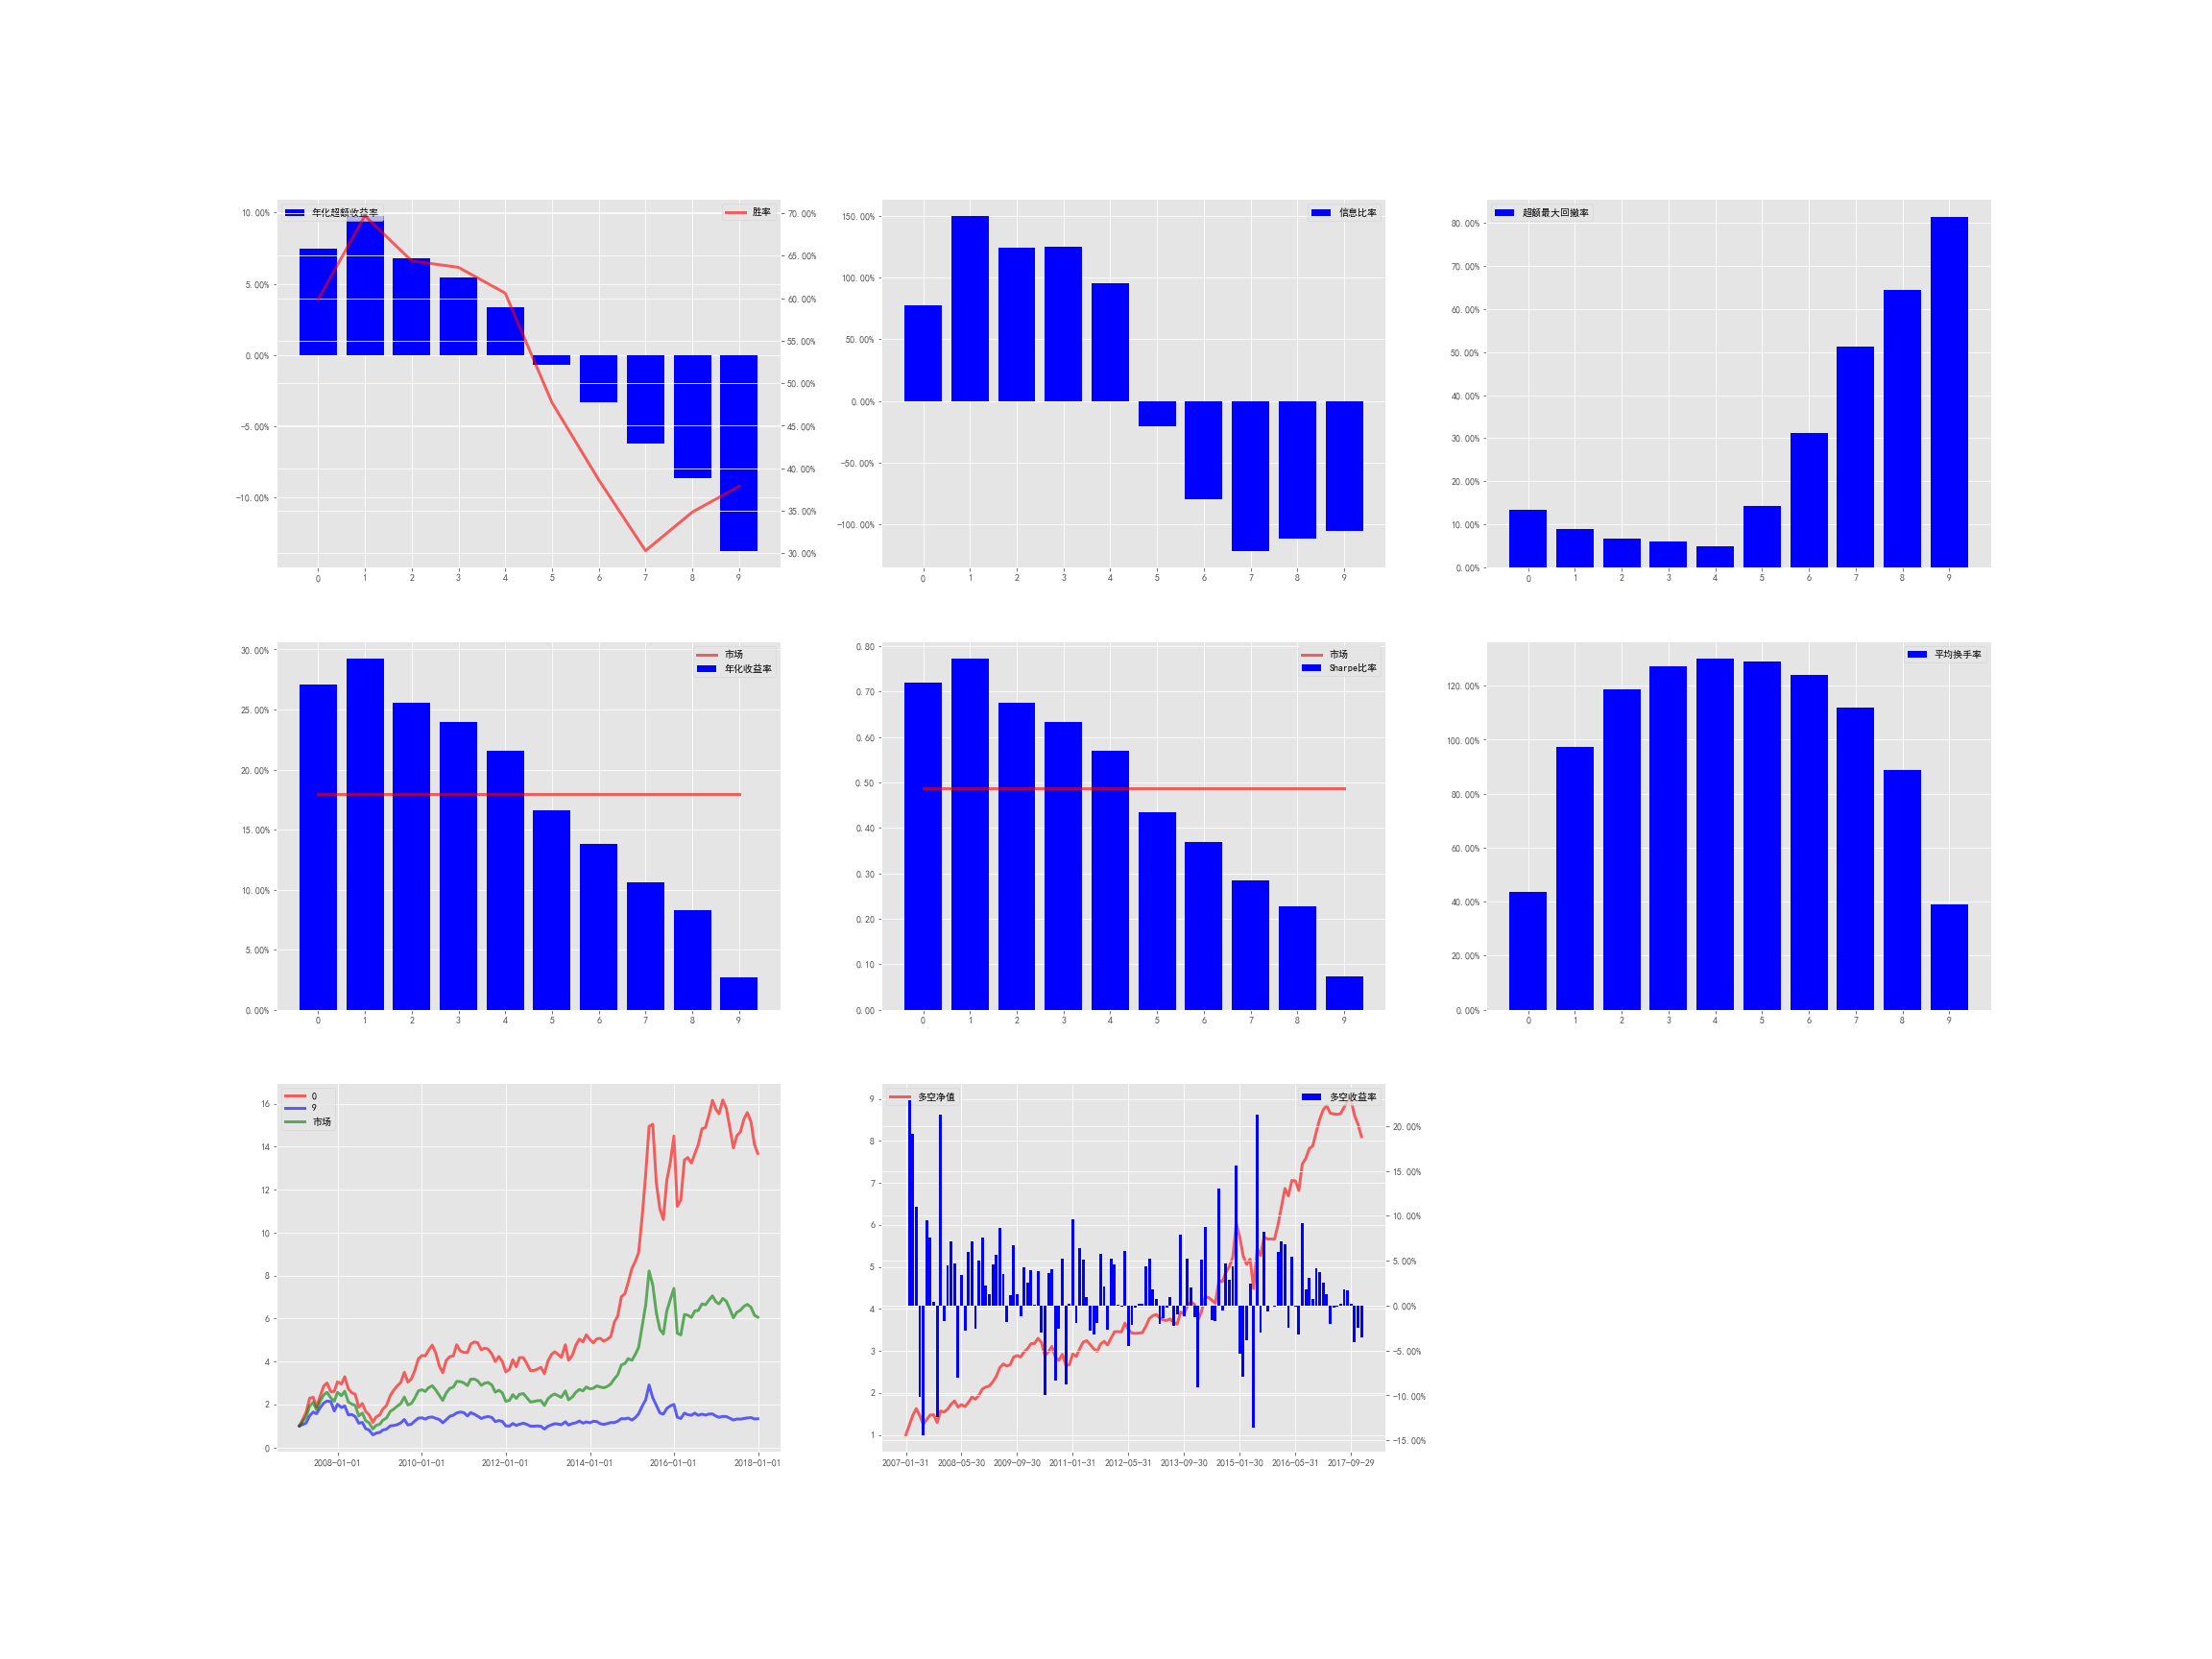
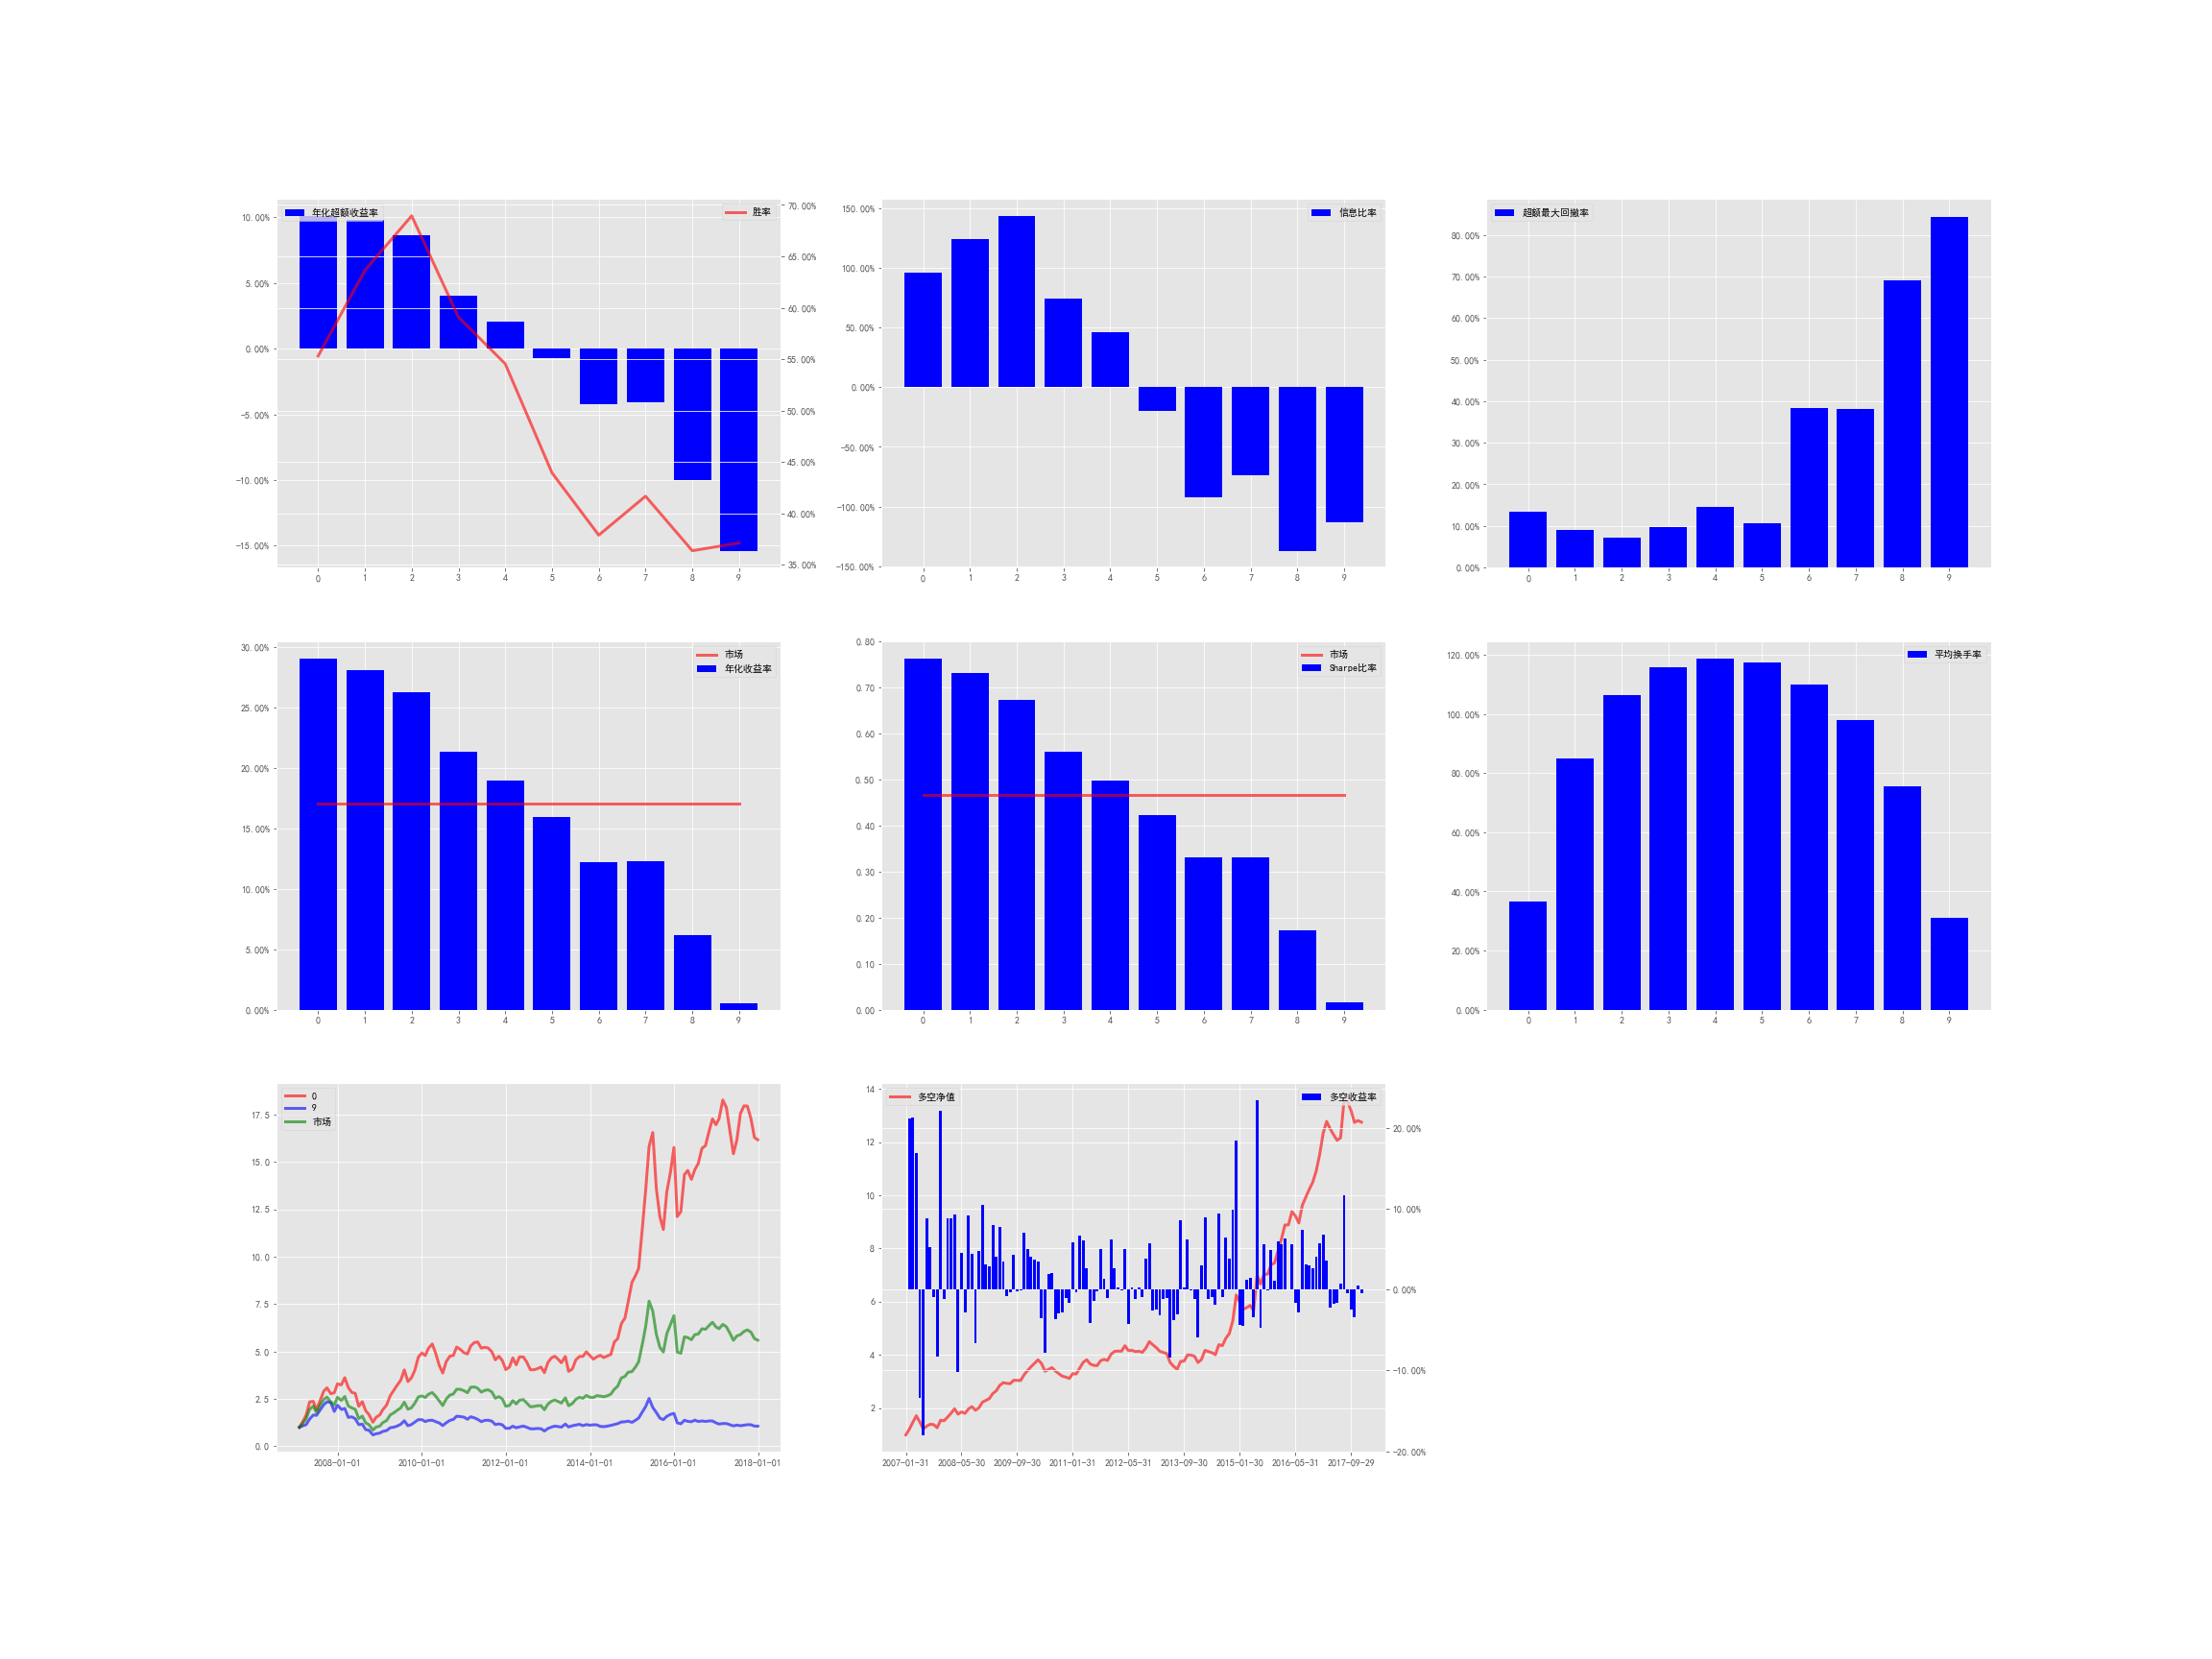
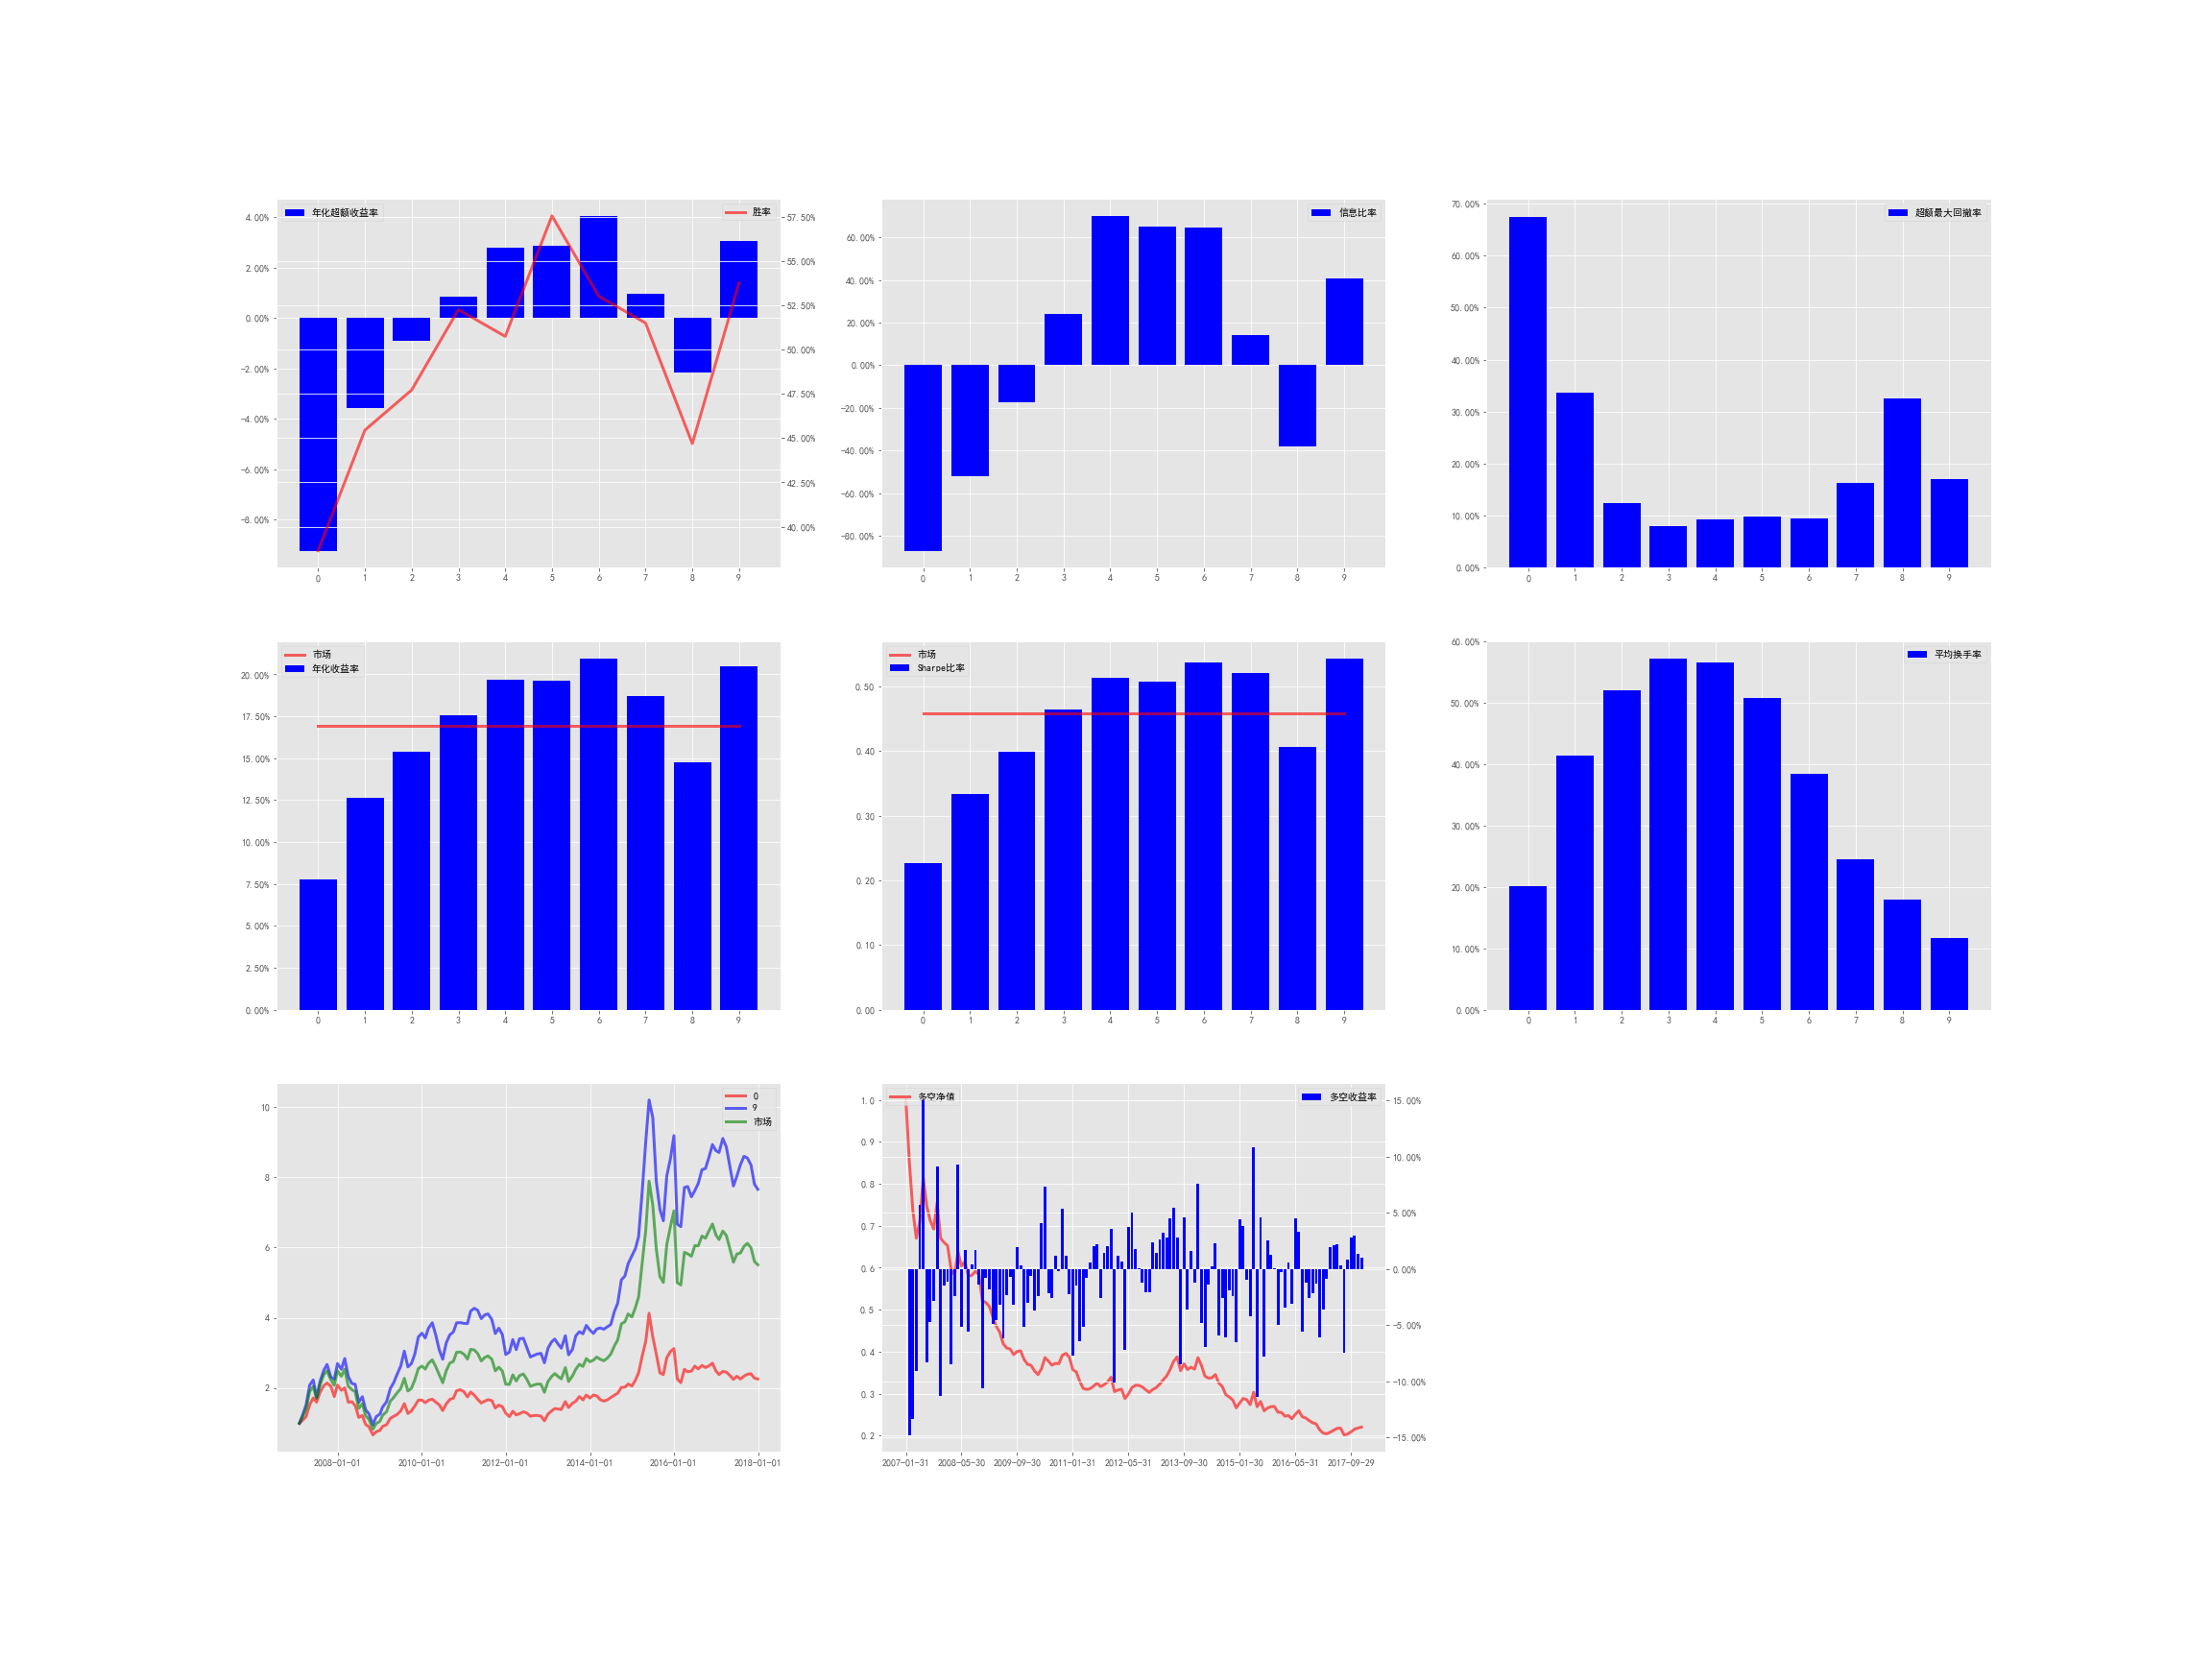
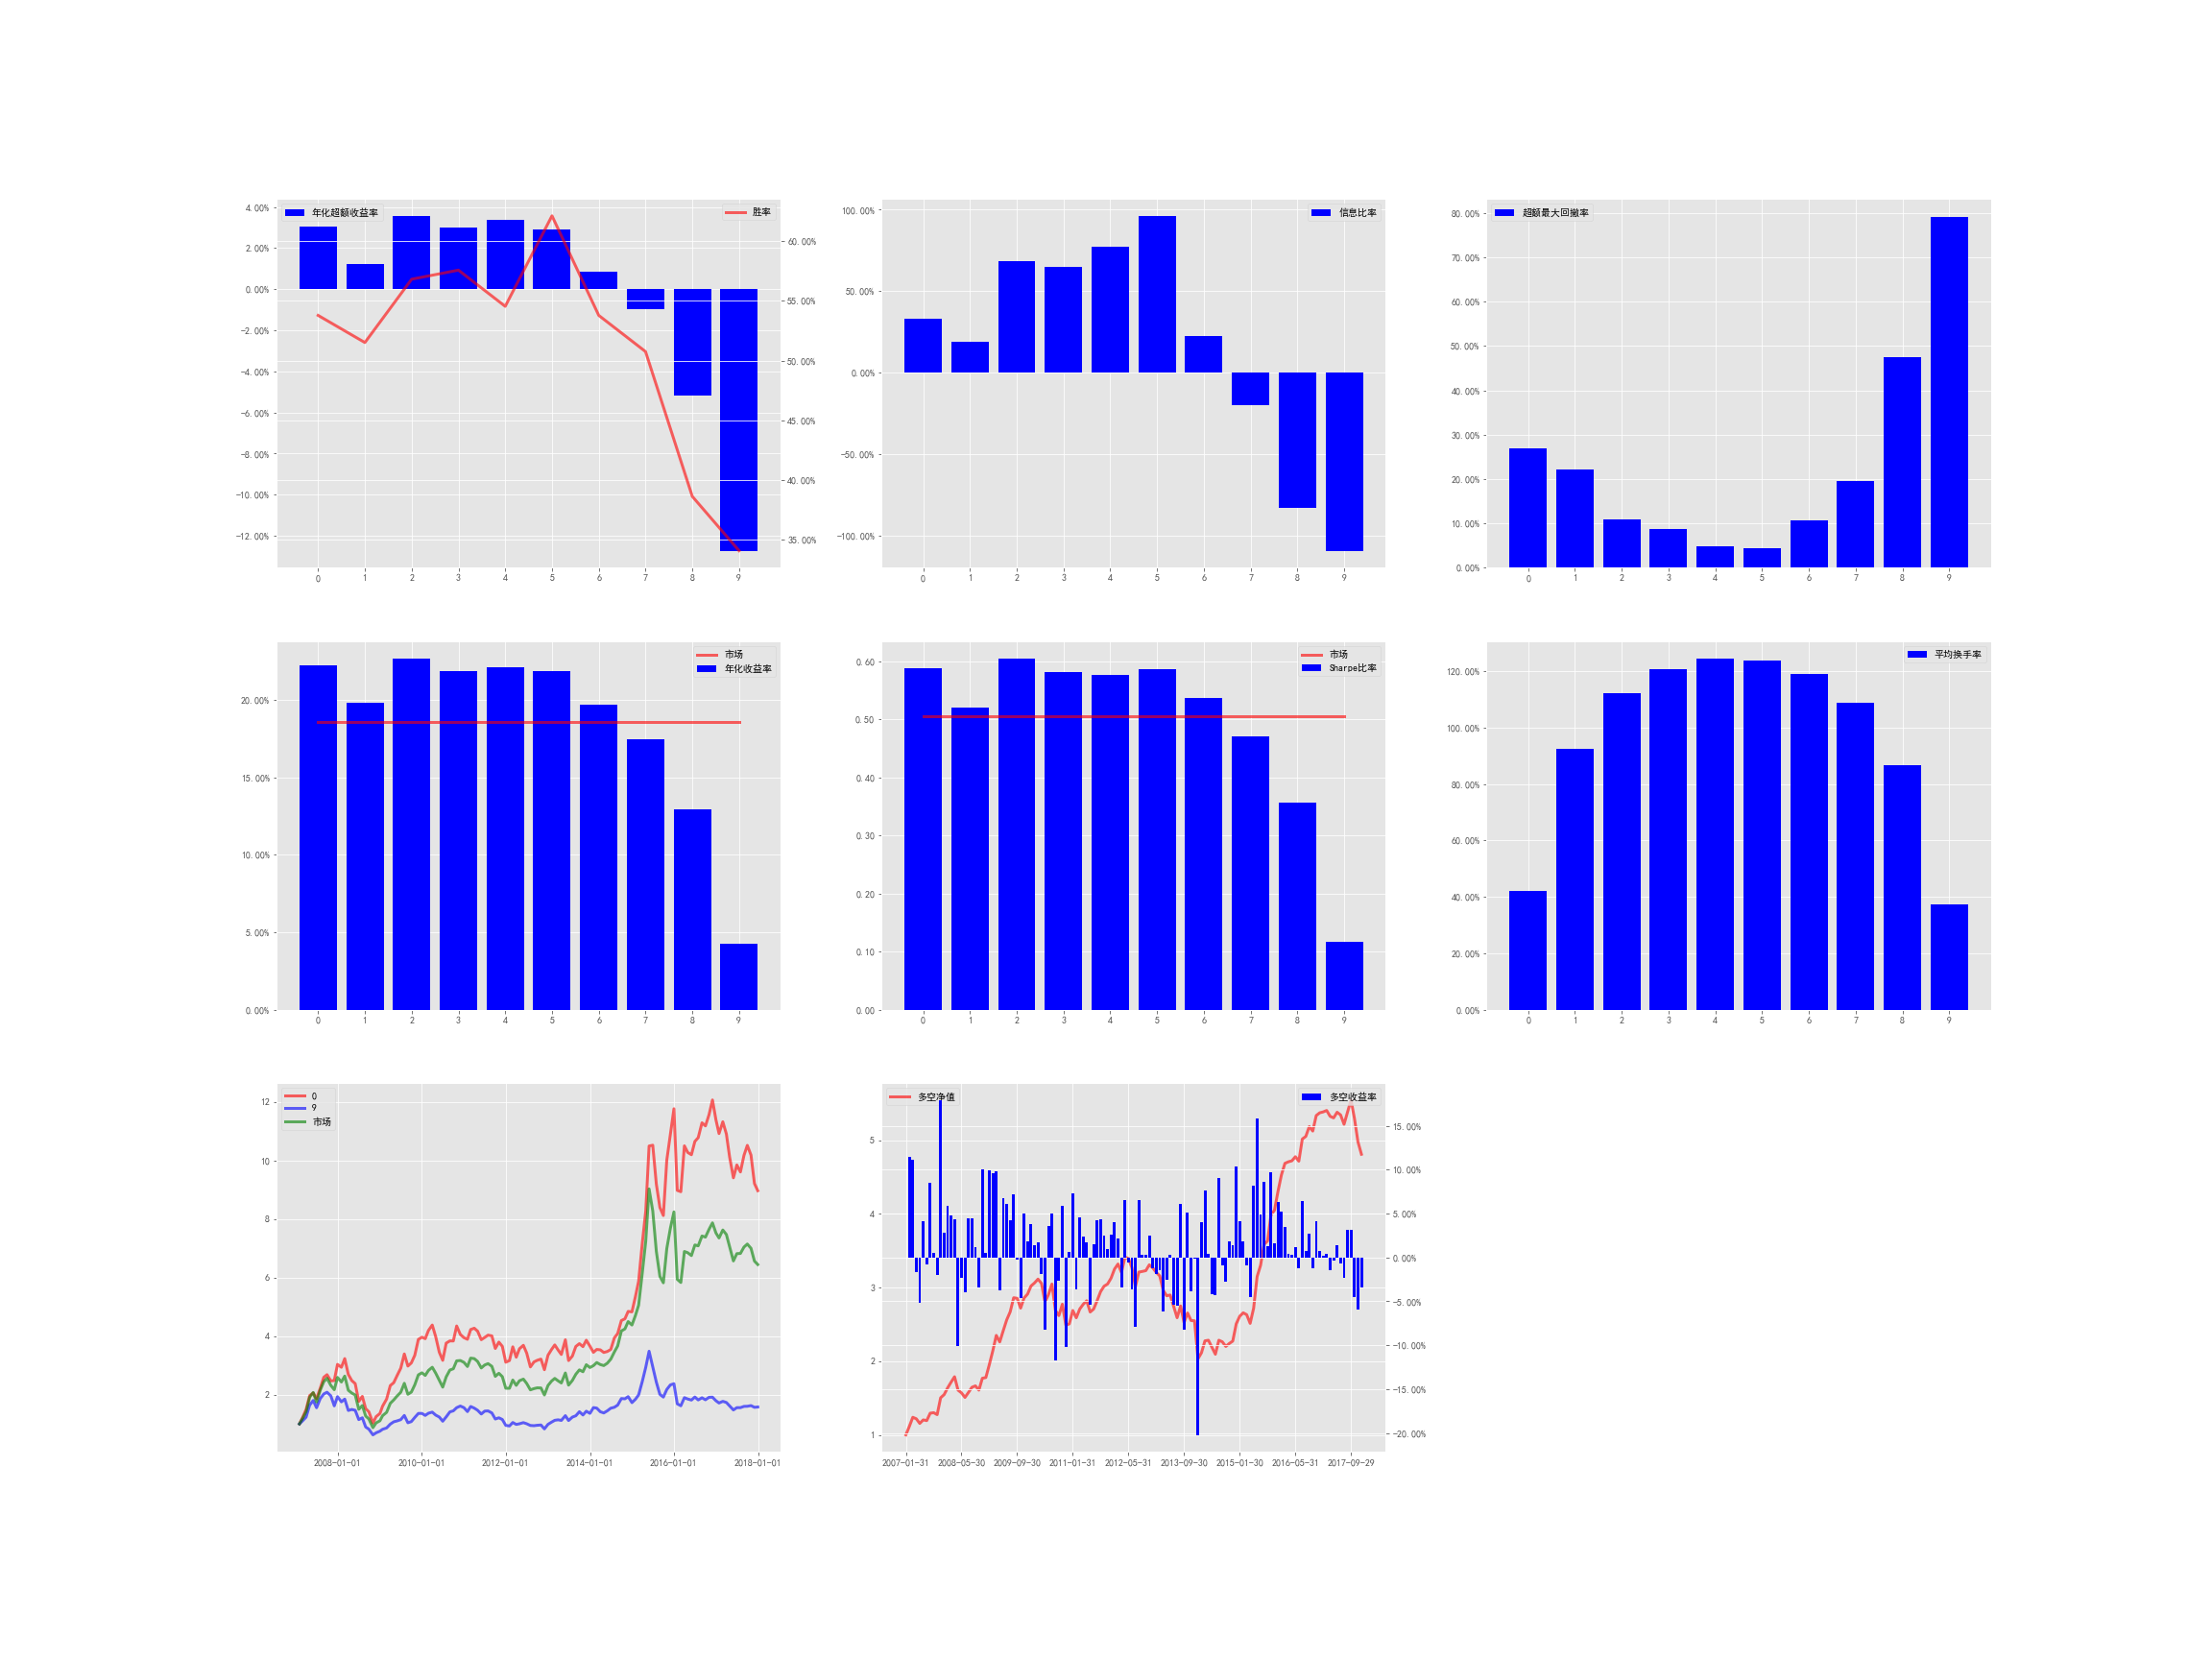
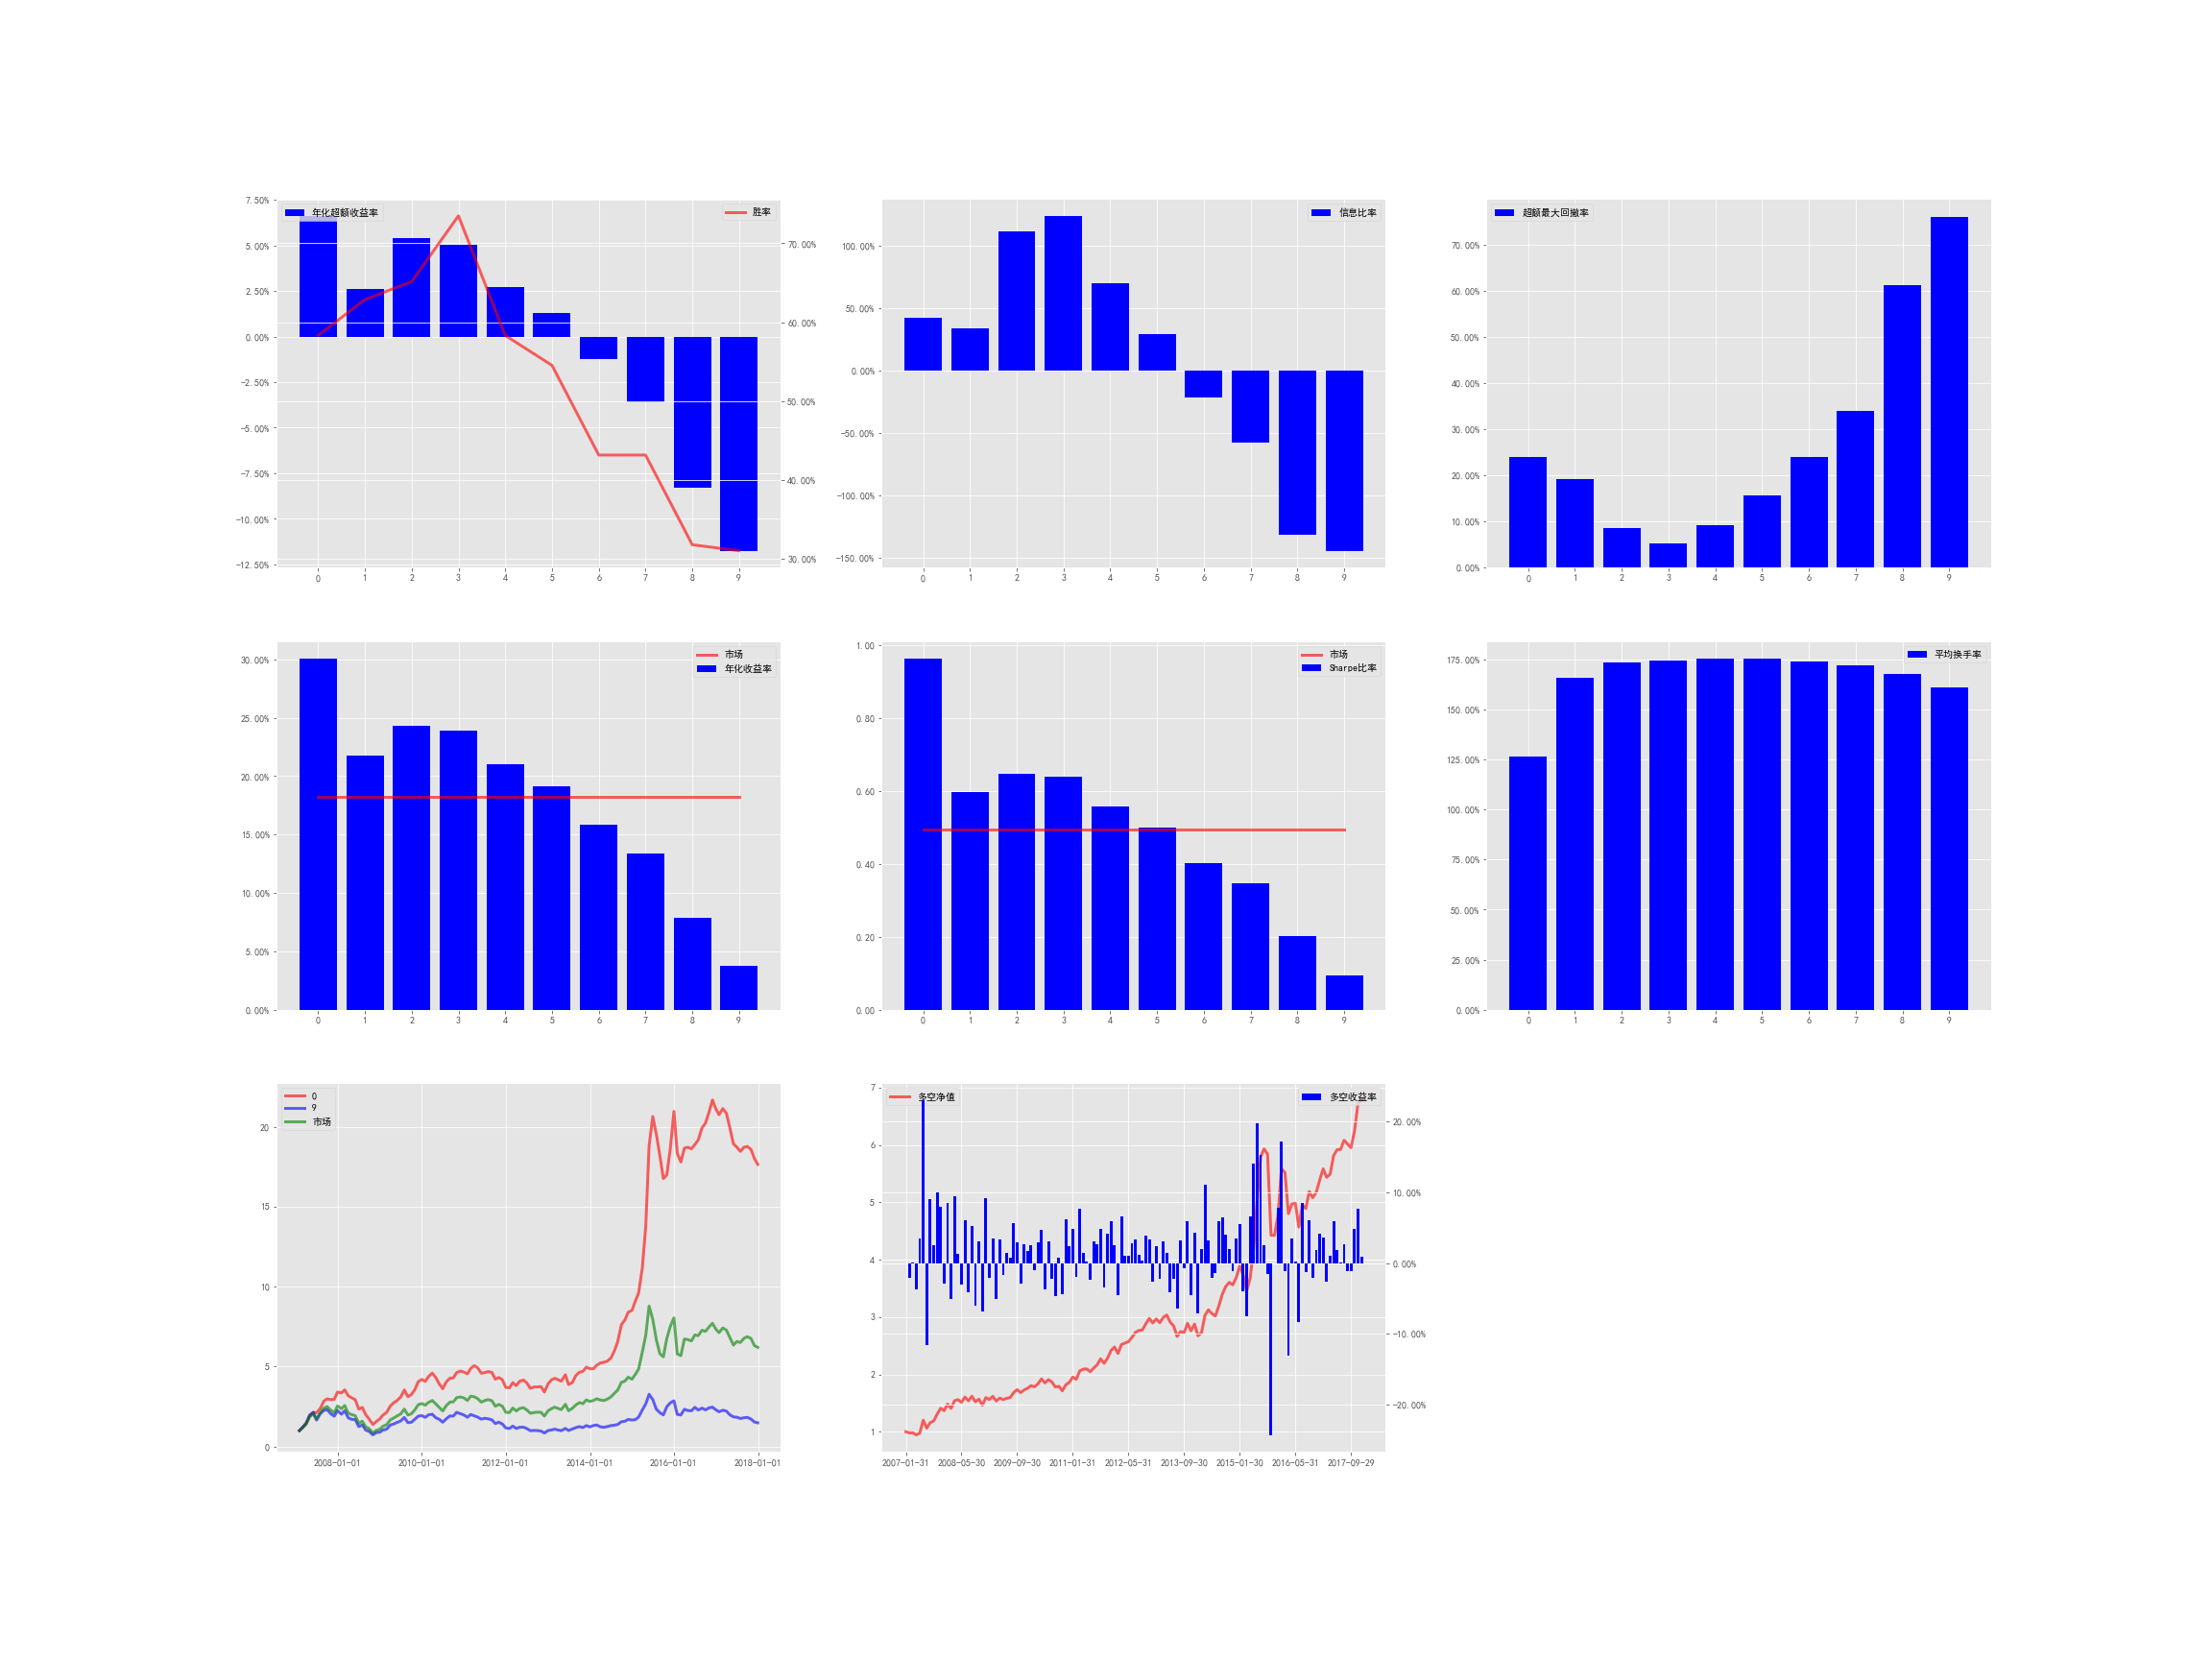
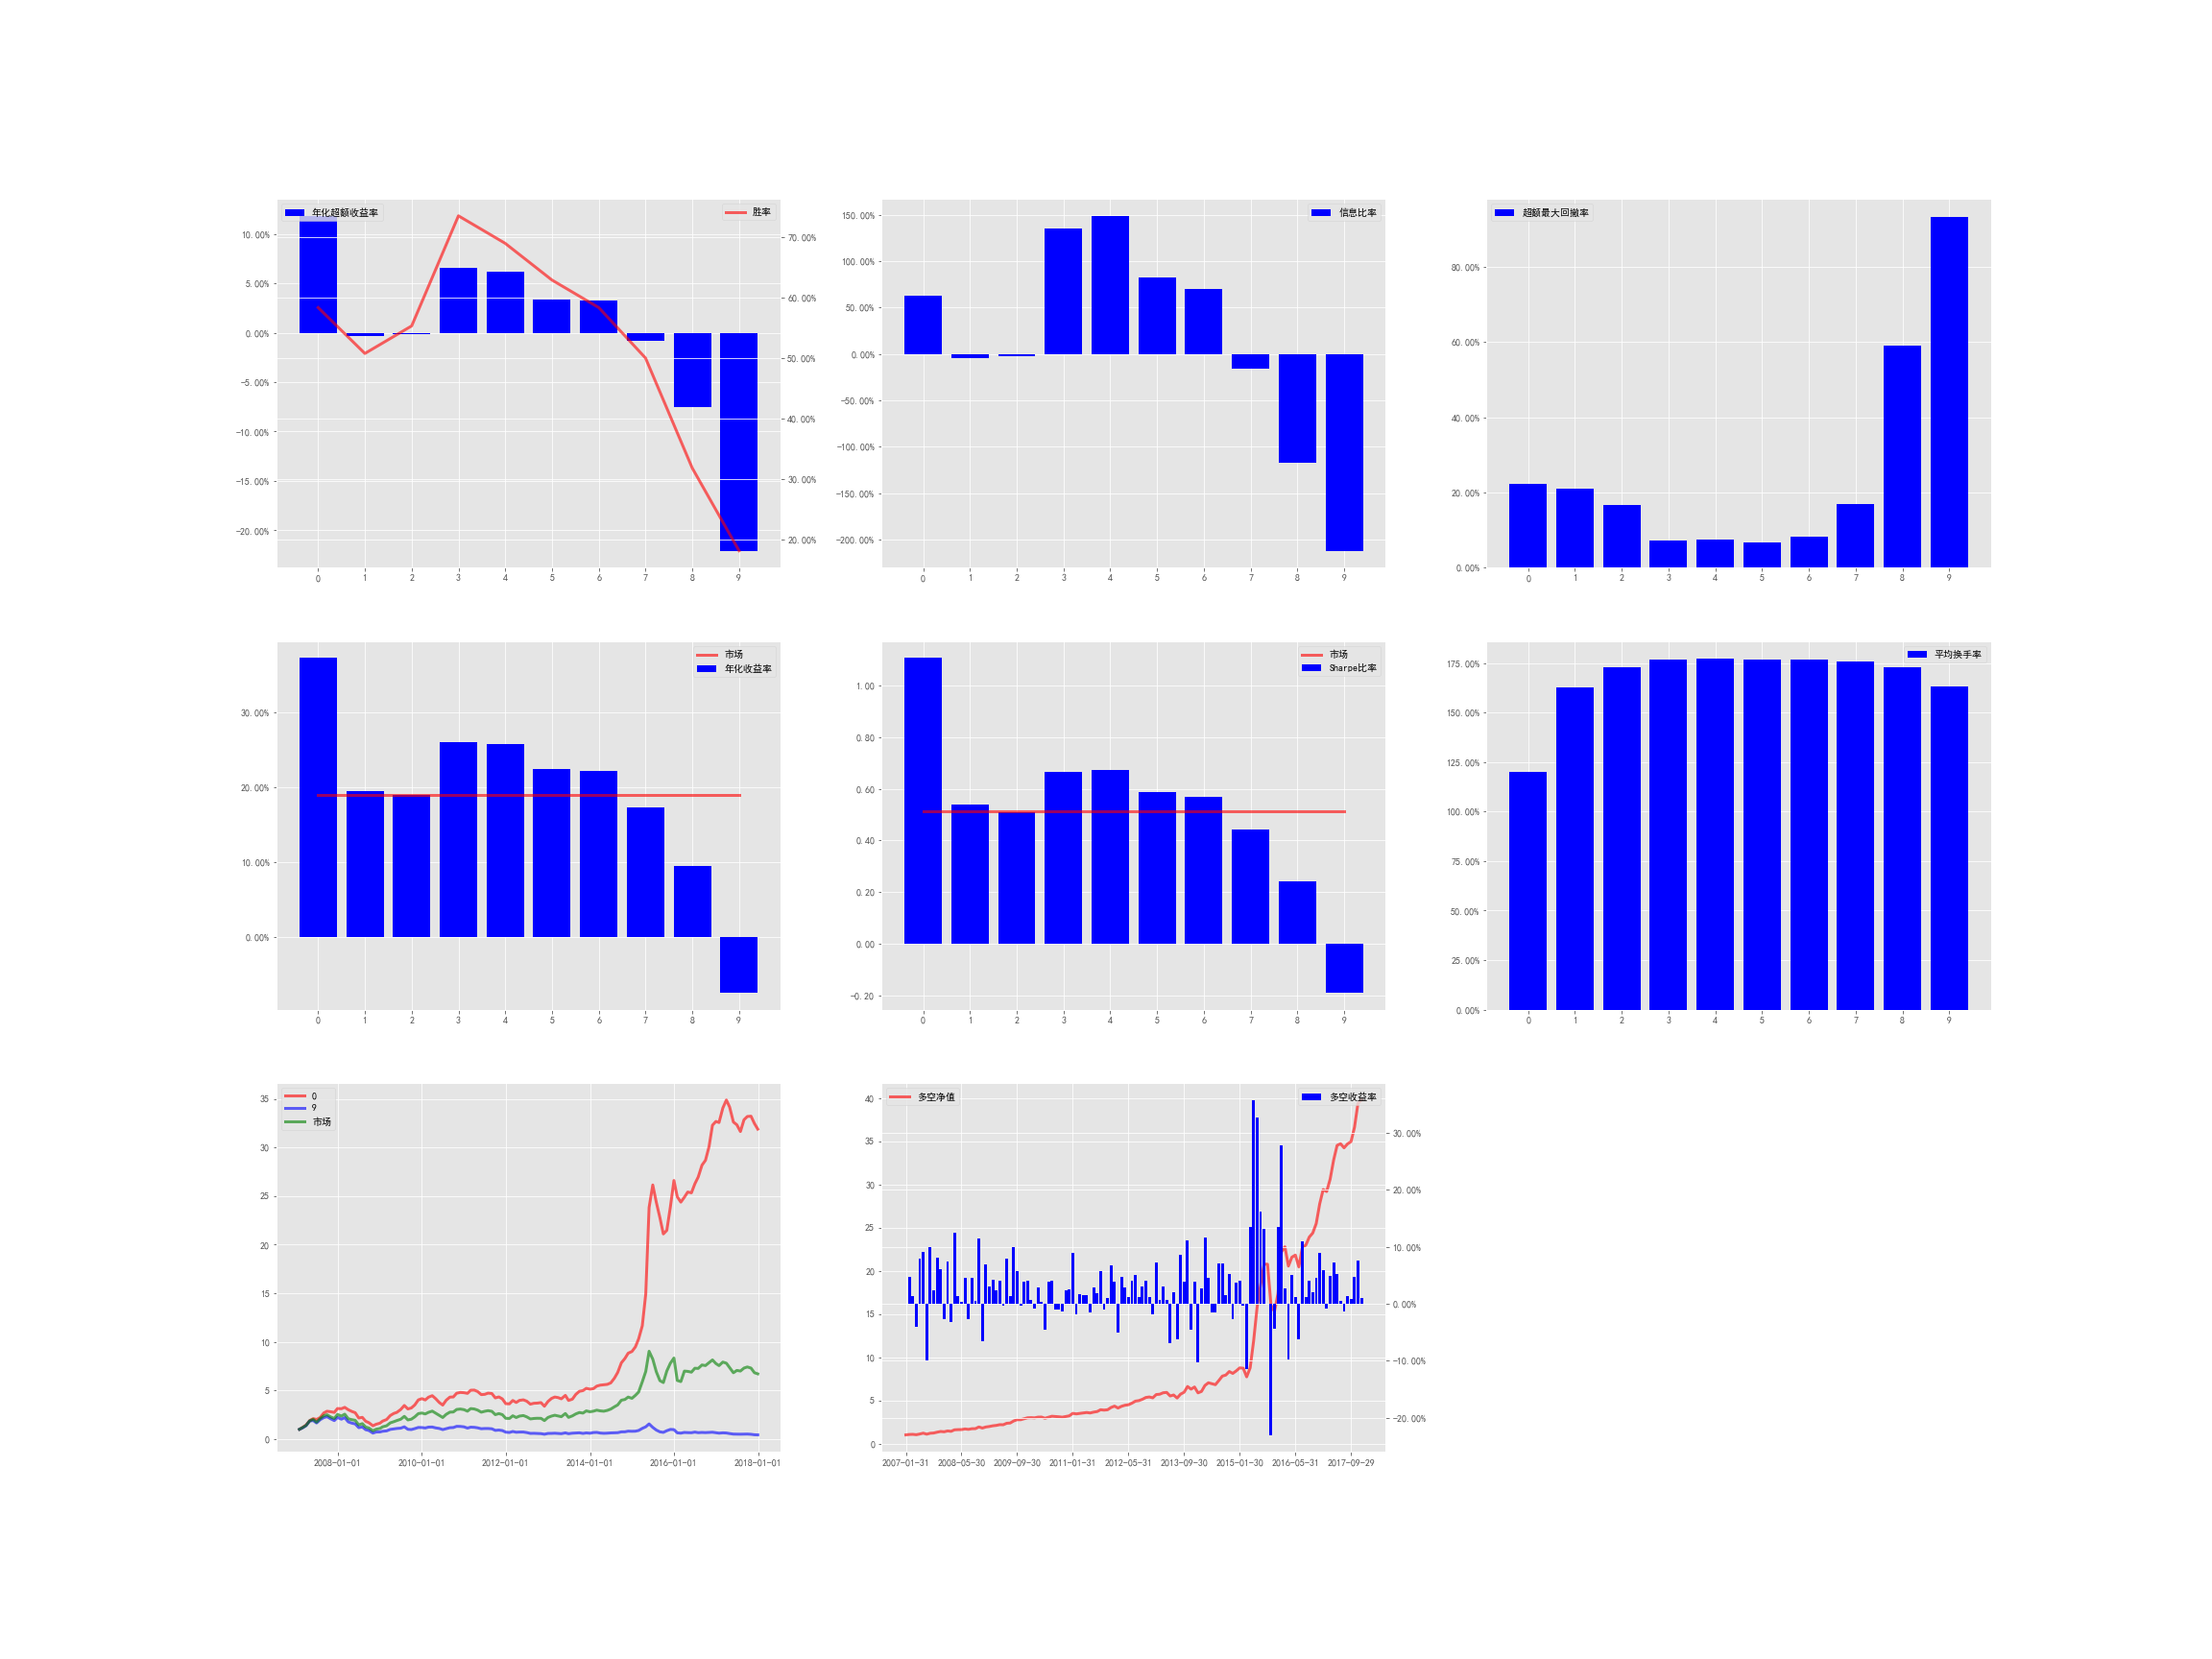
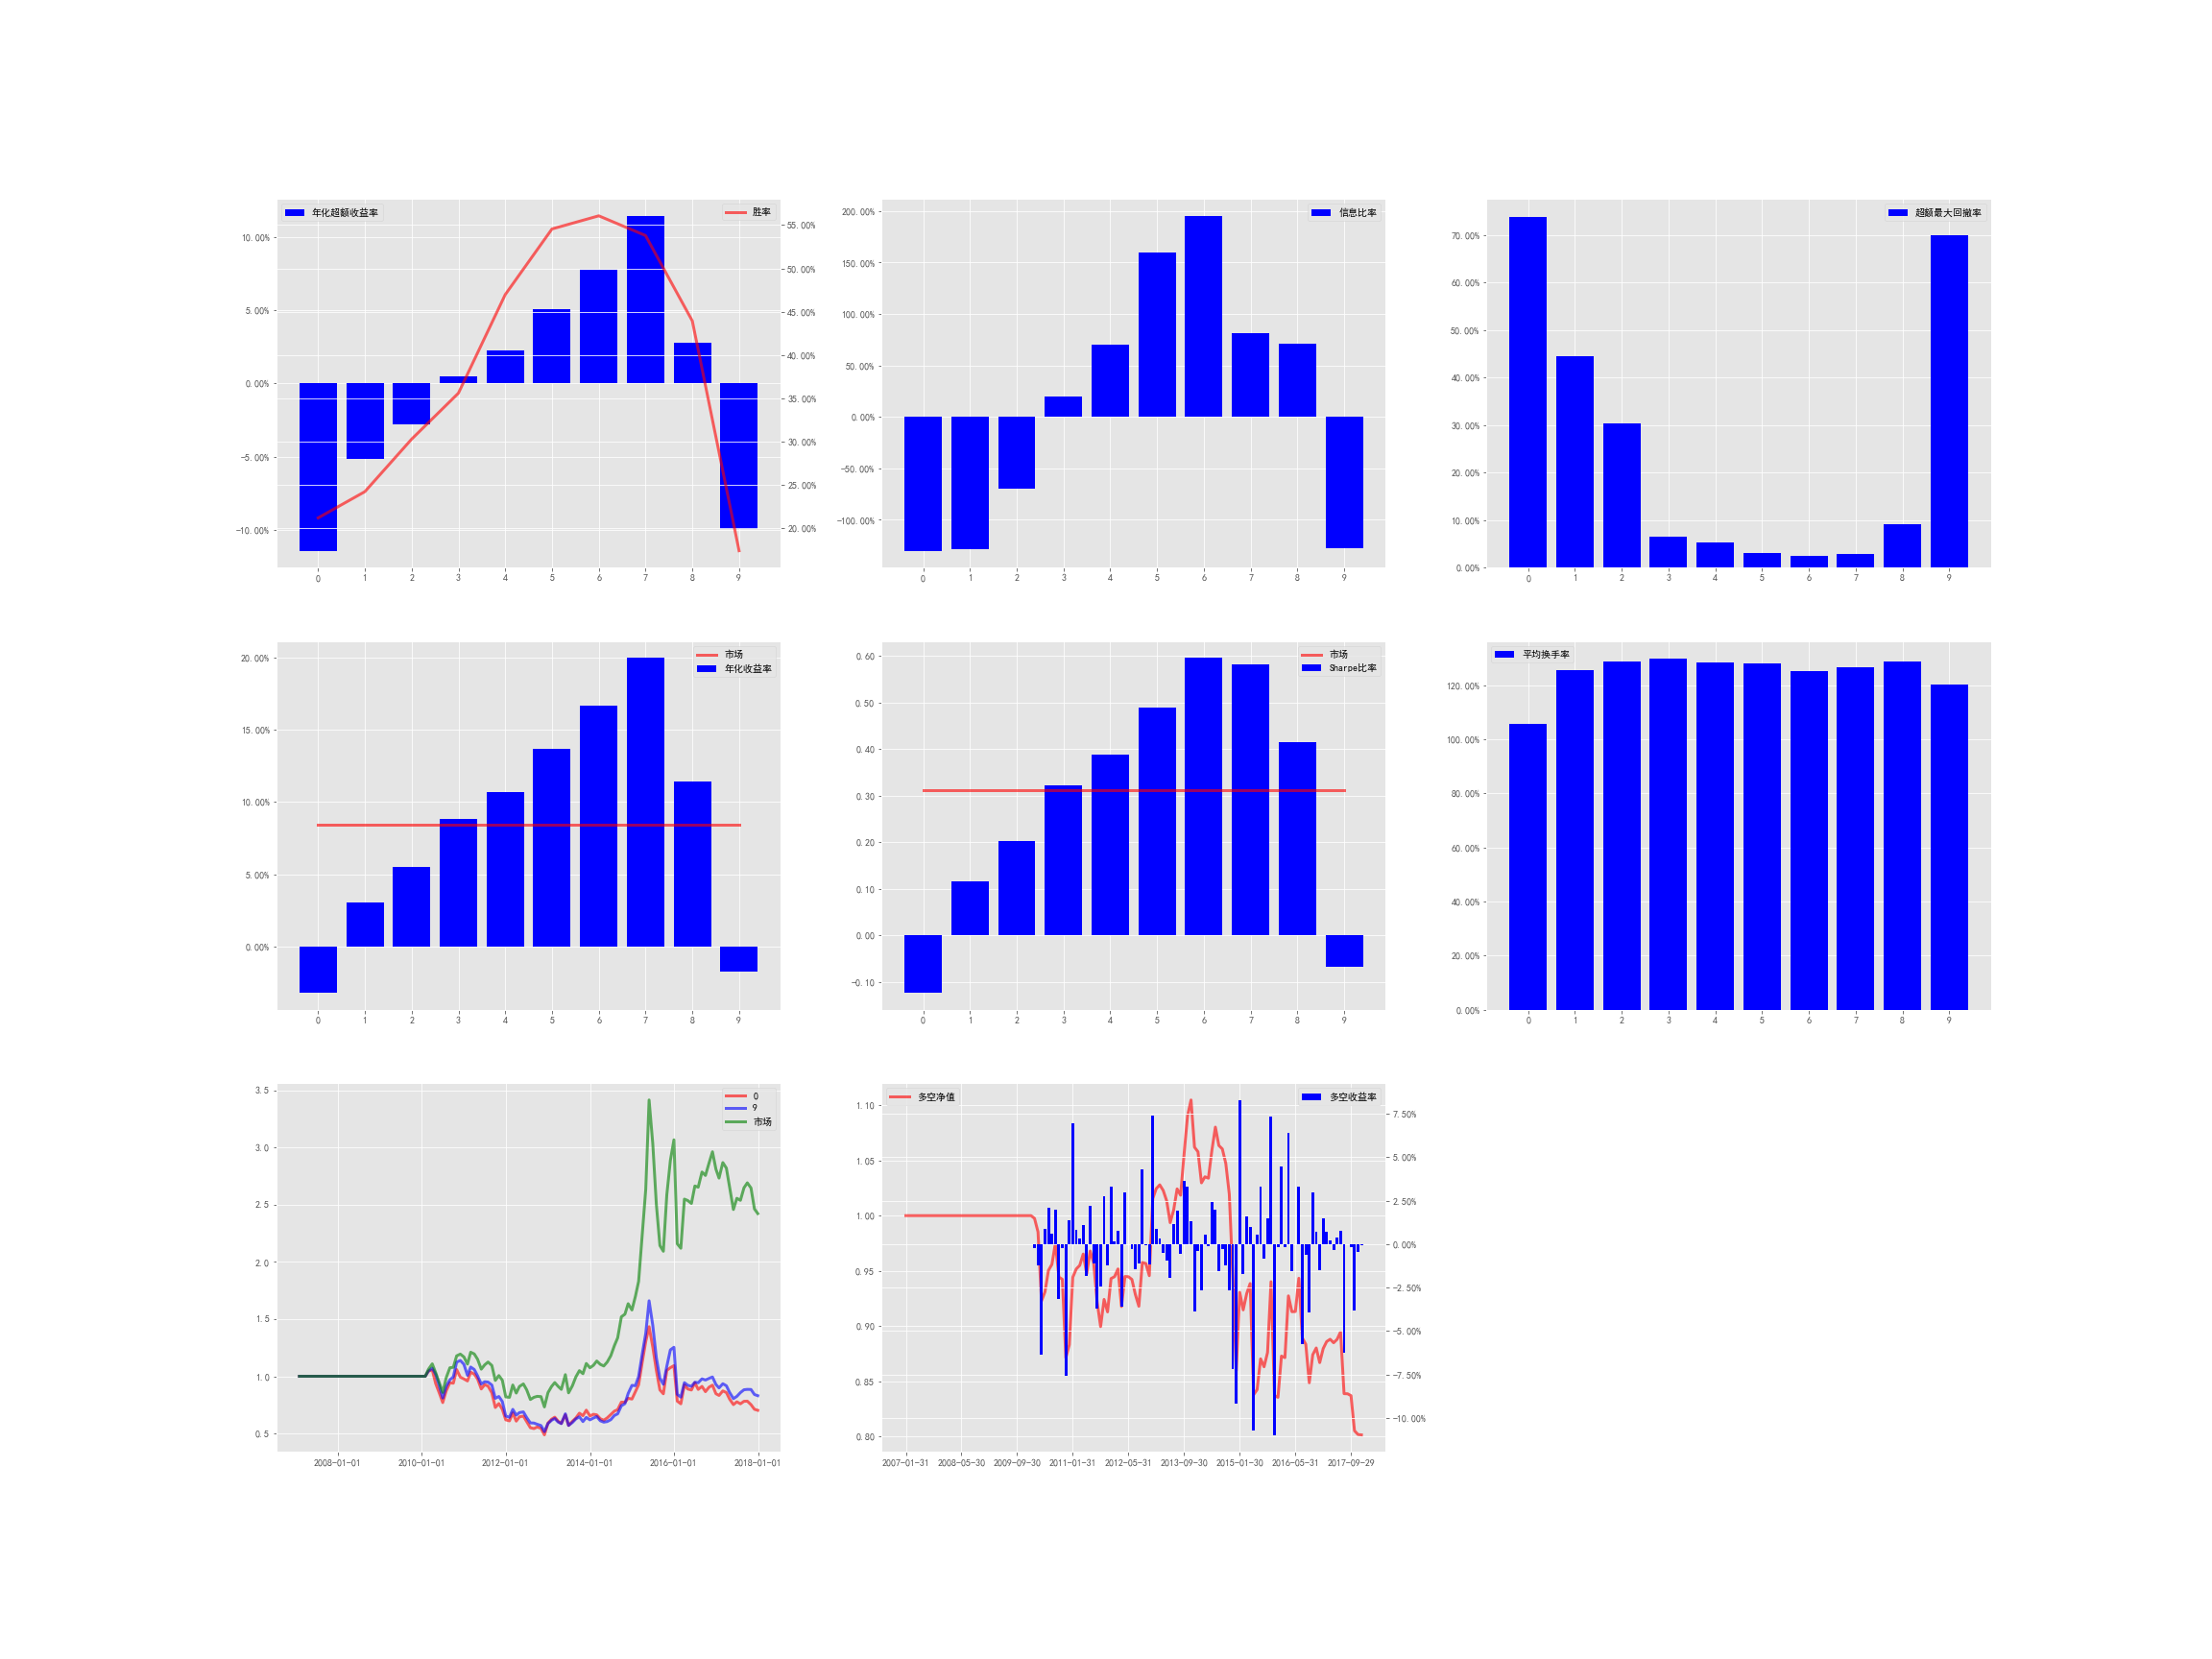
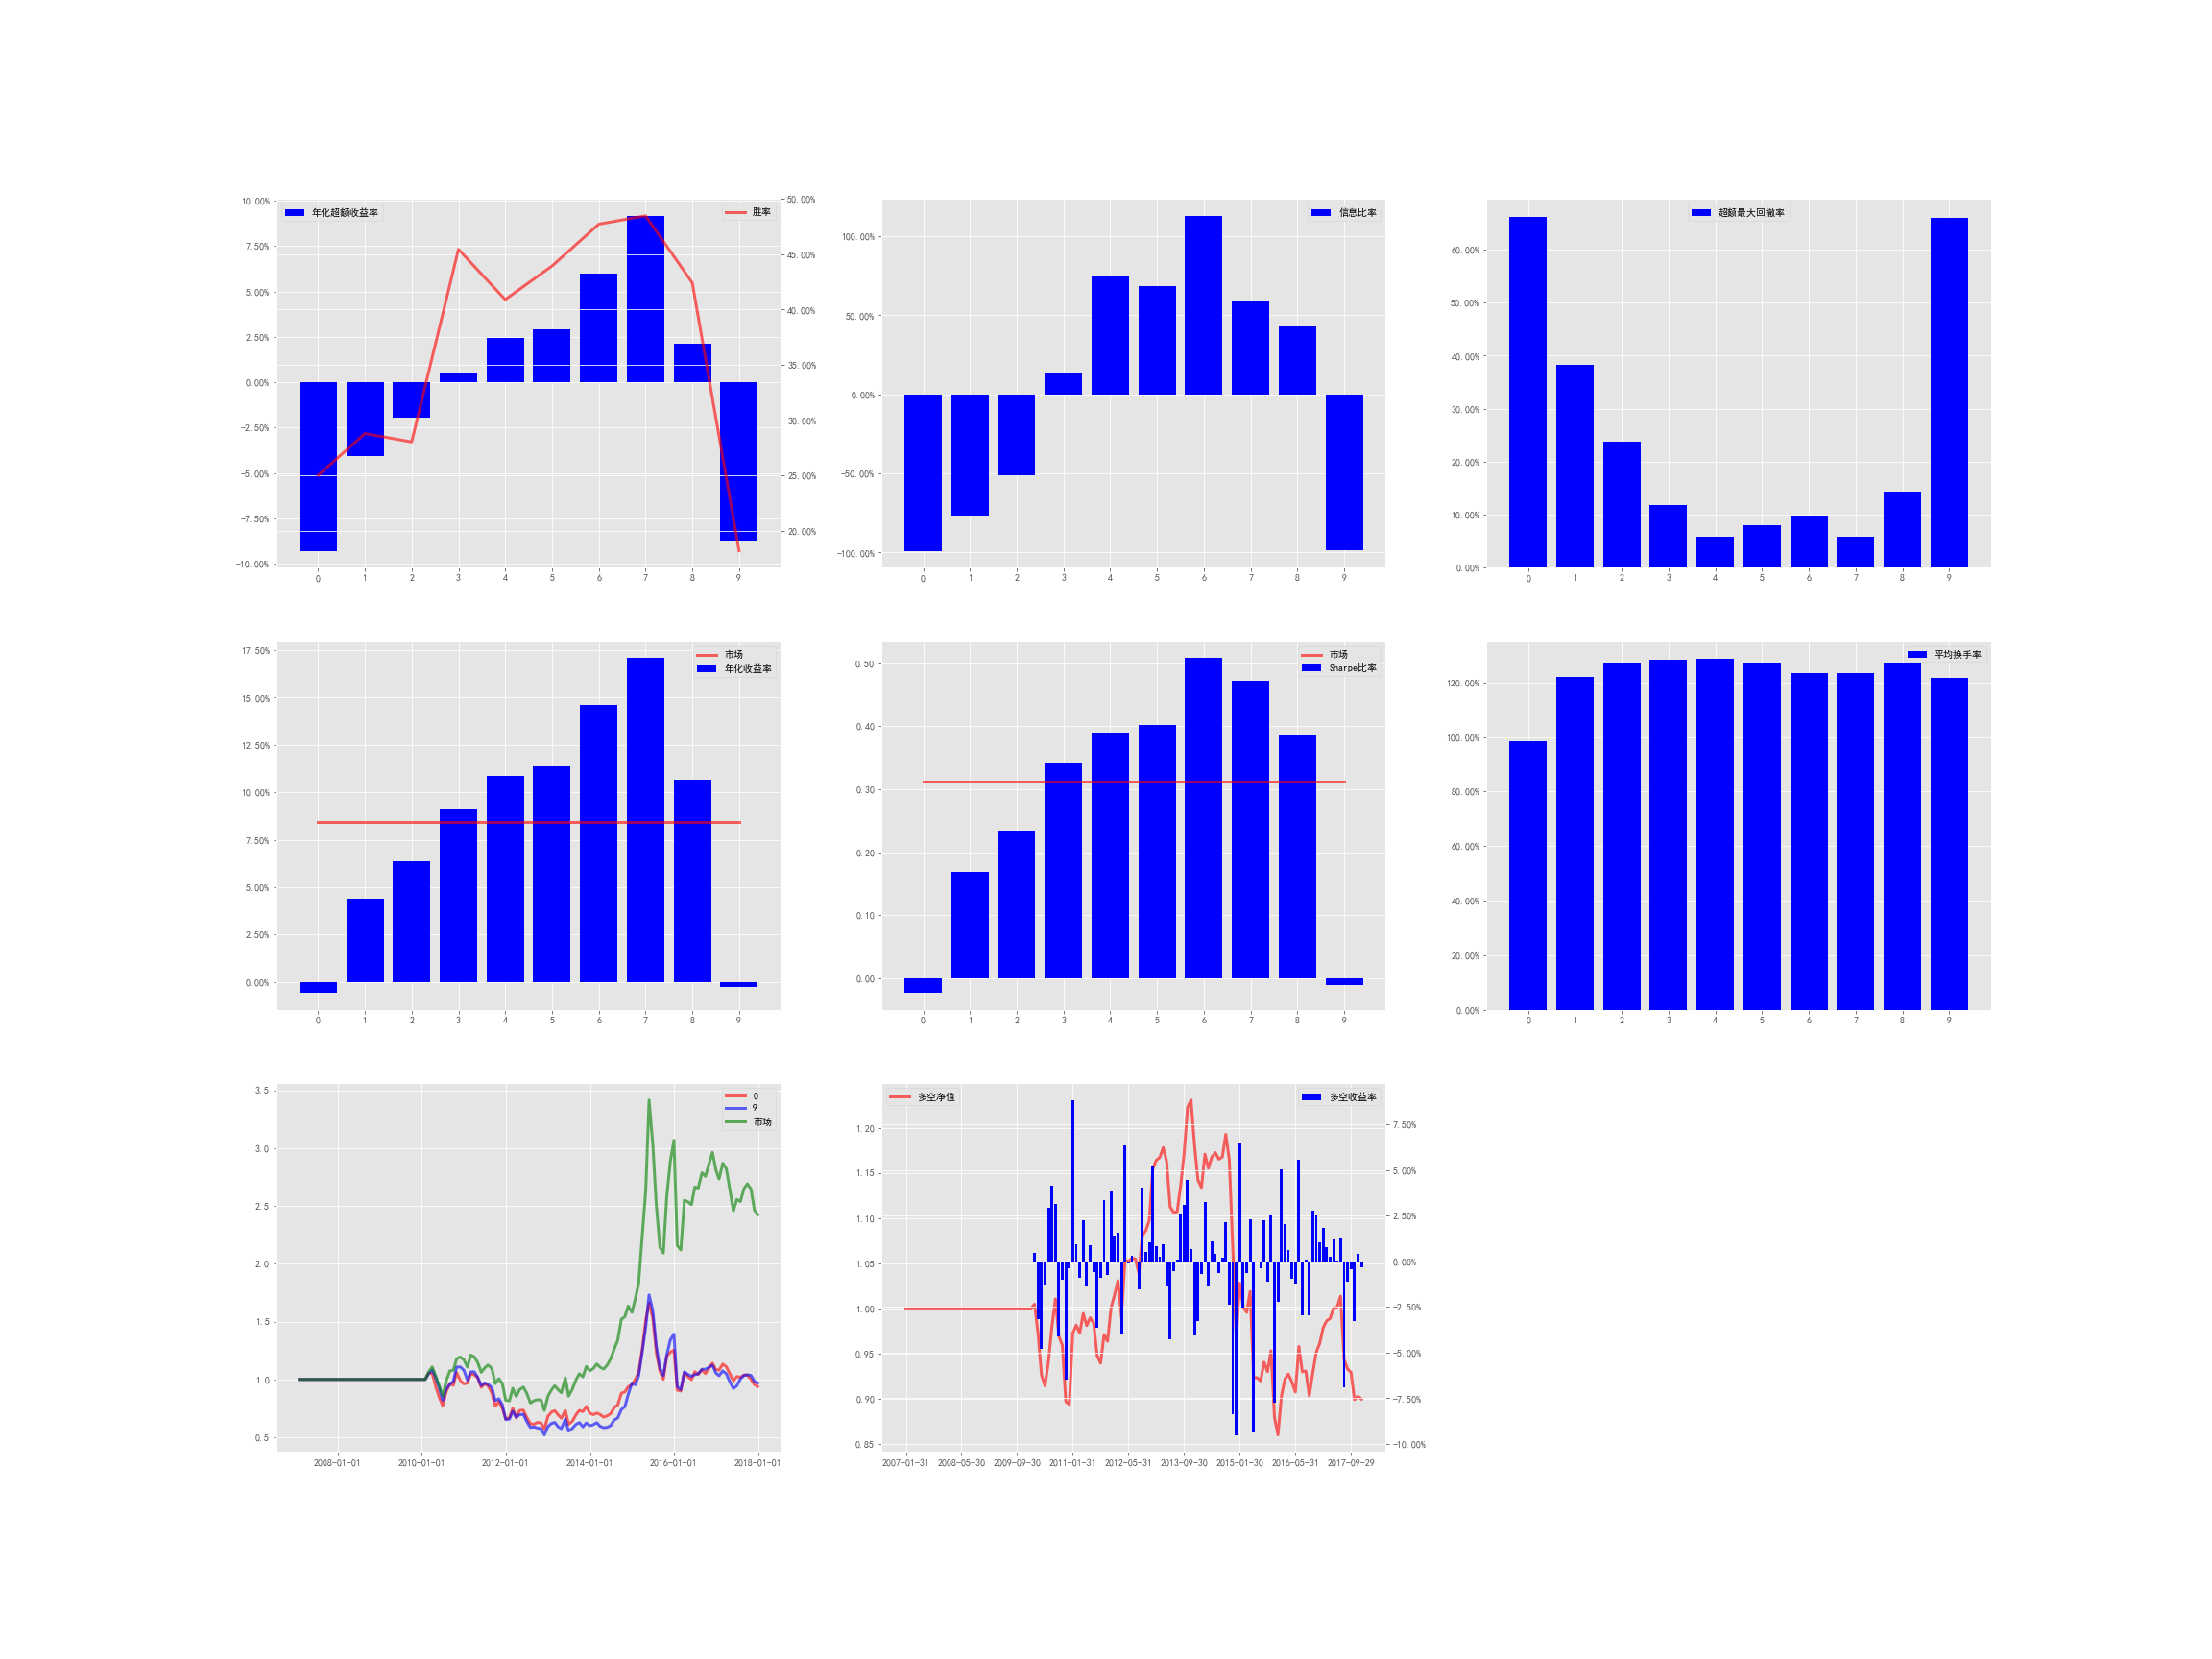
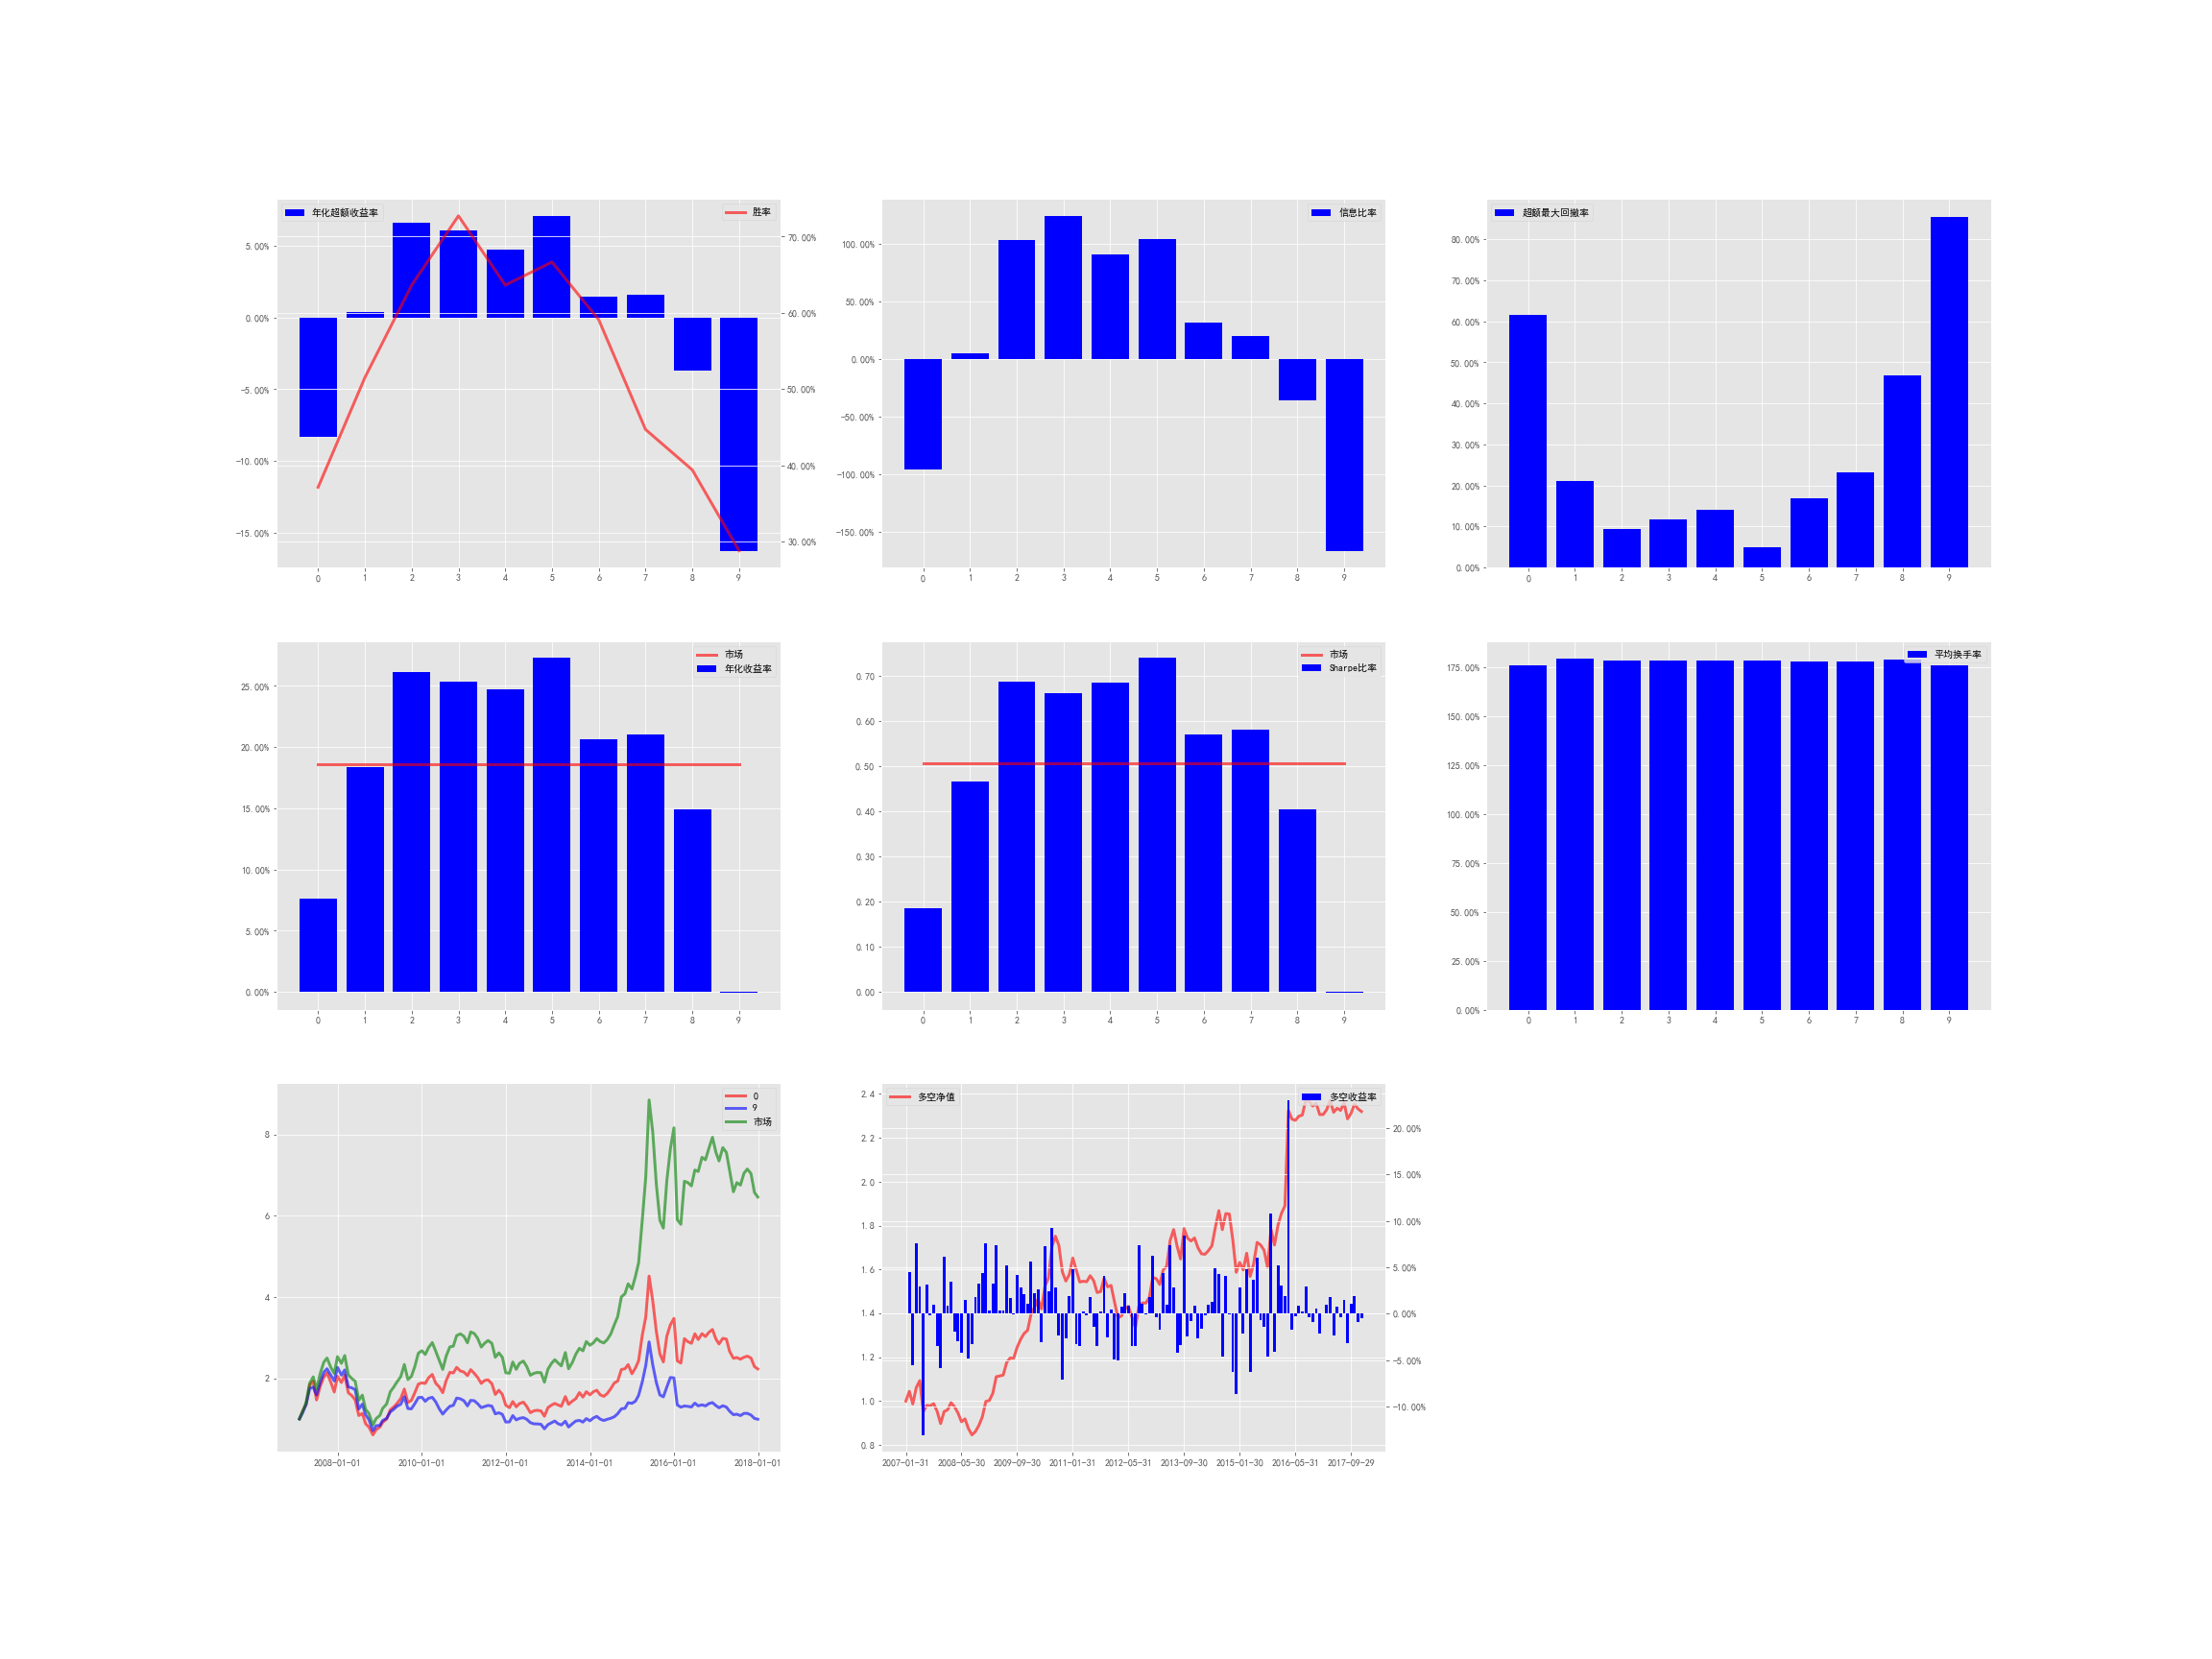

In [2]:
if __name__=='__main__':
    import matplotlib
    matplotlib.pyplot.ioff()
    import QuantStudio.api as QS
    
    # 创建因子库
    HDB = QS.FactorDB.HDF5DB()
    HDB.connect()
    
    # 创建自定义因子表
    MainFT = QS.FactorDB.CustomFT("MainFT")
    ElementaryFT = HDB.getTable("ElementaryFactor")
    DTs = ElementaryFT.getDateTime(ifactor_name="复权收盘价", start_dt=dt.datetime(2007, 1, 1), end_dt=dt.datetime(2018, 1, 1))
    MonthLastDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)
    FactorNames = FactorInfo.index.tolist()
    MainFT.addFactors(factor_table=ElementaryFT, factor_names=["复权收盘价", "中信行业", "是否在市"], args={})
    MainFT.addFactors(factor_table=HDB.getTable("StyleMomentumFactor"), factor_names=FactorNames, args={})
    MainFT.setDateTime(MonthLastDTs)
    MainFT.setID(ElementaryFT.getID(ifactor_name="复权收盘价"))
    
    # 创建回测模型
    Model = QS.BackTest.BackTestModel()
    # --------因子测试模块--------
    # IC 测试
    iModule = QS.BackTest.SectionFactor.IC(factor_table=MainFT)
    iModule["测试因子"] = FactorNames
    iModule["排序方向"] = FactorInfo["排序方向"].loc[FactorNames].to_dict()
    iModule["价格因子"] = "复权收盘价"
    iModule["计算时点"] = MonthLastDTs
    iModule["筛选条件"] = "@是否在市==1"
    Model.Modules.append(iModule)
    # 分位数组合测试
    for iFactorName in FactorNames:
        iModule = QS.BackTest.SectionFactor.QuantilePortfolio(factor_table=MainFT)
        iModule["测试因子"] = iFactorName
        iModule["排序方向"] = FactorInfo.loc[iFactorName, "排序方向"]
        iModule["价格因子"] = "复权收盘价"
        iModule["调仓时点"] = MonthLastDTs
        iModule["筛选条件"] = "@是否在市==1"
        Model.Modules.append(iModule)
    
    # 运行模型
    TestDateTimes = MainFT.getDateTime()
    Model.run(dts=TestDateTimes)
    
    display(Model)